# Experimento04: Redes convolucionales por canales

## Librerías

In [2]:
# Librerias necesarias
import os

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':40,
         'ytick.labelsize': 40
}
plt.rcParams.update(params)
# Seaborn conf
import seaborn as sns
sns.set(style='darkgrid')
sns.set_palette(sns.color_palette("Blues"))

import sys

#Procesado de datos
import pandas as pd
import numpy as np
import operator

#Modelos
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from nltk import ngrams

from keras.layers import Dense, Embedding, Flatten, GlobalMaxPool1D, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers

from keras.initializers import Constant

from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import tensorflow as tf

from sklearn import preprocessing
from nltk import ngrams

## Carga de conjunto de datos

In [3]:
df_training = pd.read_csv("./data/ds_training_processed.csv")
df_testing = pd.read_csv("./data/ds_testing_processed.csv")

X_train = df_training["text"]
y_train = df_training["sentiment"]
X_test = df_testing["text"]
y_test = df_testing["sentiment"]

y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

## Carga de modelos de representación

In [4]:
def load_representation_model(file_name, include_embedding_matrix=False):
    res = {}
    with open("./repmodels/"+file_name+".txt", 'r') as d:
        res["model"] = d.readline()
    res["train_text_features"] = np.load("./repmodels/"+file_name+"_train.npy")
    res["test_text_features"] = np.load("./repmodels/"+file_name+"_test.npy")

    if include_embedding_matrix:
        res["embedding_matrix"] = np.load("./repmodels/"+file_name+"_embeddingmatrix.npy")

    return res

vsm_binary = load_representation_model("vsm_binary")
vsm_binary_ngrams = load_representation_model("vsm_binary_ngrams")
vsm_tfidf = load_representation_model("vsm_tfidf")
vsm_tfidf_ngrams = load_representation_model("vsm_tfidf_ngrams")
embedding_padding = load_representation_model("embedding_padding")
embedding_glove = load_representation_model("embedding_glove", include_embedding_matrix=True)

# Cargo esto por facilidad
vsm_model = []
vsm_model.append(vsm_binary)
vsm_model.append(vsm_binary_ngrams)
vsm_model.append(vsm_tfidf)
vsm_model.append(vsm_tfidf_ngrams)

## Funciones generales

In [5]:
pd.set_option('display.max_colwidth', 2000)
vocab_size = 29773
emb_dim = 50
num_words = 29773

results = []
def add_to_results(classifier, repmodel, predict_x, y_test):
    y_pred = np.argmax(predict_x,axis=1)

    results.append({"classifier": classifier,
                    "rep.model": repmodel,
                    "accuracy": accuracy_score(y_test, y_pred),
                    "precision": precision_score(y_test, y_pred, average="weighted"),
                    "recall": recall_score(y_test,y_pred, average="weighted")
                    })

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'bo', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel("Epochs")
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def nn_classification_report(predict_x, y_test, class_names):
    y_pred = np.argmax(predict_x,axis=1)

    print("Classification Report")
    print

    print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    plot_confusion_matrix(cm, classes=class_names)

    print("Final Accuracy")
    print(accuracy_score(y_test, y_pred))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def join_csv_for_experiment(experiment_string, number_of_experiements):
    experiments_data = []
    for i in range(1, number_of_experiements+1):
        experiments_data.append( pd.read_csv("exp_"+experiment_string+"_"+str(i)+".csv") )

    res = pd.concat(experiments_data, ignore_index=True)
    res.to_csv("exp_"+experiment_string+".csv")

## Clasificadores

In [6]:
results = []

# depthwise separable convolutions
def depthwise_block(x, 
                    filter, 
                    kernel_size, 
                    pooling_size, 
                    dropout):
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv1D(filter, kernel_size, padding="same")(x)

    if dropout > 0:
        x = layers.Dropout(dropout)(x)

    x = layers.MaxPooling1D(pool_size=pooling_size, padding="same")(x)

    return x

def build_exp04(name, 
                description, 
                repmodel, 
                input_shape,
                exp="Exp04",
                embedding=None,
                number_of_filters=[64,128,256],
                kernel_size=4,
                dense_neurons=128,
                block_dropout=0.0,
                general_dropout=0.0, 
                pooling_size=4
                ):

    inputs = keras.Input(shape=input_shape, dtype="float")

    if embedding:
        x = embedding(inputs)
        x = layers.Conv1D(number_of_filters[0], kernel_size, activation="relu")(x)        
    else:
        x = layers.Conv1D(number_of_filters[0], kernel_size, activation="relu")(inputs)
    
    depthwise = []
    for size in number_of_filters:
        depthwise.append( depthwise_block(x, size, kernel_size, pooling_size, block_dropout) )
    
    x = layers.Concatenate()(depthwise)
    
    x = layers.Conv1D(number_of_filters[-1], 1, activation="relu")(x)

    if general_dropout > 0:
        x = layers.Dropout(general_dropout)(x)

    x = layers.GlobalMaxPooling1D()(x)

    if dense_neurons>0:
        x = layers.Dense(dense_neurons, activation="relu")(x)

    outputs = layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model._name = exp+name
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print(model.summary())
    history = model.fit(repmodel["train_text_features"].astype(float), y_train_2, 
                        epochs=40, batch_size=32,validation_split=0.2, 
                        callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=7, min_delta=0.01)])
    plot_history(history)
    predict_x=model.predict(repmodel["test_text_features"].astype(float))
    nn_classification_report(predict_x, y_test, ["negative","positive"])
    add_to_results(model._name+" "+description, repmodel["model"], predict_x, y_test)



Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 4997, 32)             160       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 4997, 32)             128       ['conv1d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_3 (Bat  (None, 4997, 32)             128       ['c

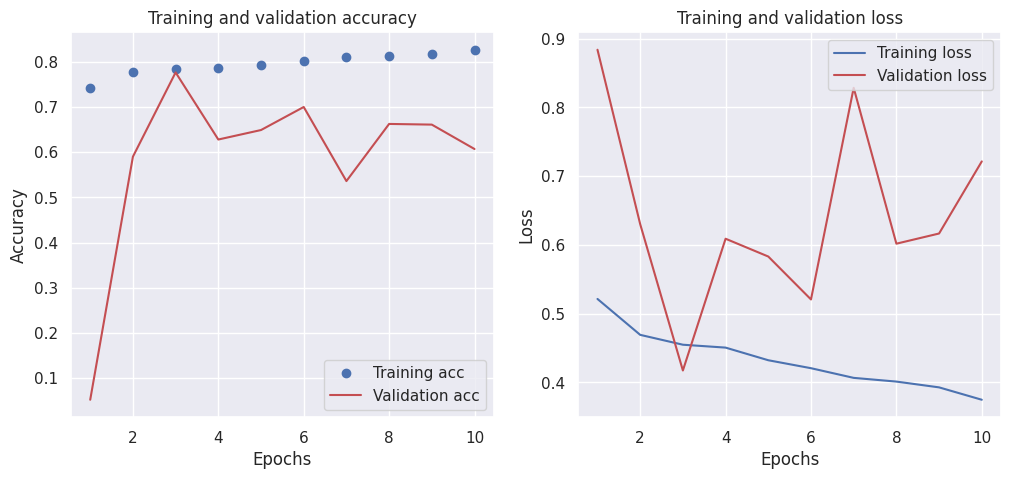

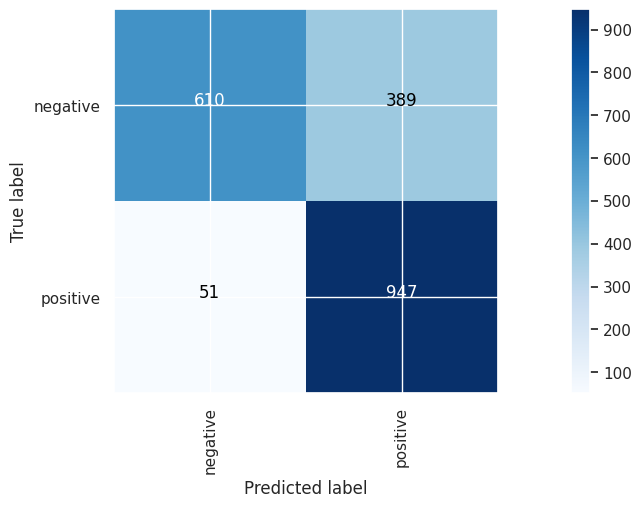

Final Accuracy
0.7796695042563846
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 4997, 32)             160       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 4997, 32)             128       ['conv1d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_6 (Bat  (None, 4

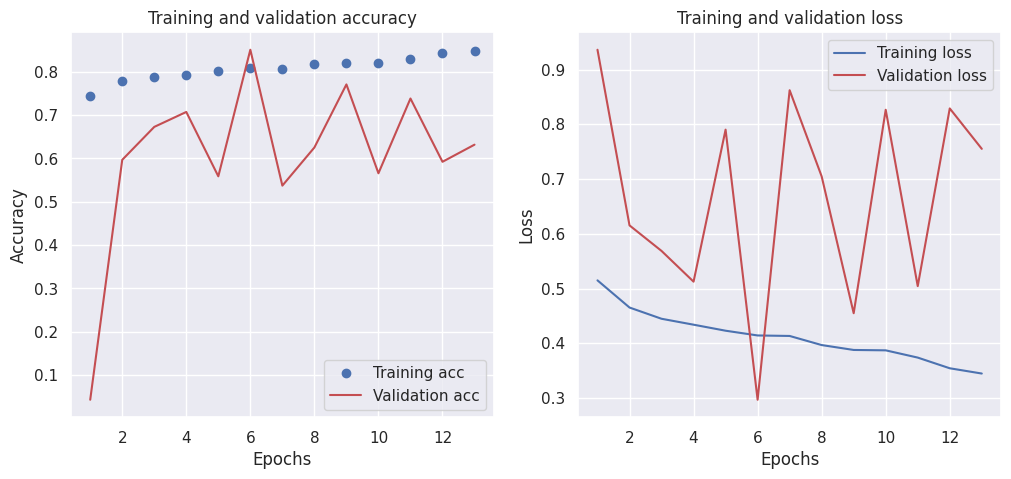

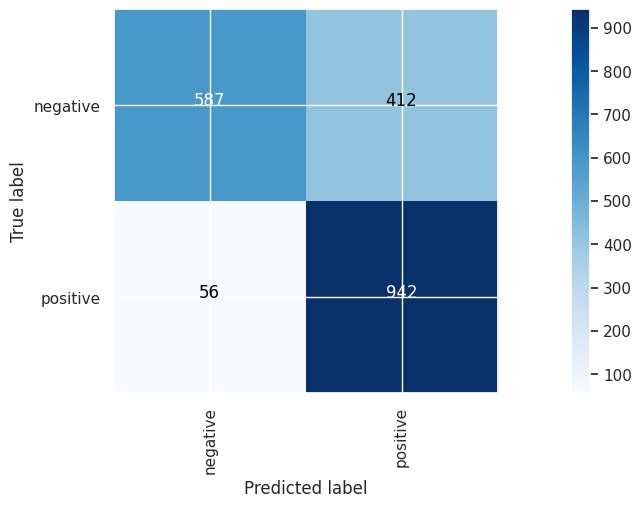

Final Accuracy
0.7656484727090636
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 4997, 32)             160       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 4997, 32)             128       ['conv1d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_9 (Bat  (None, 4

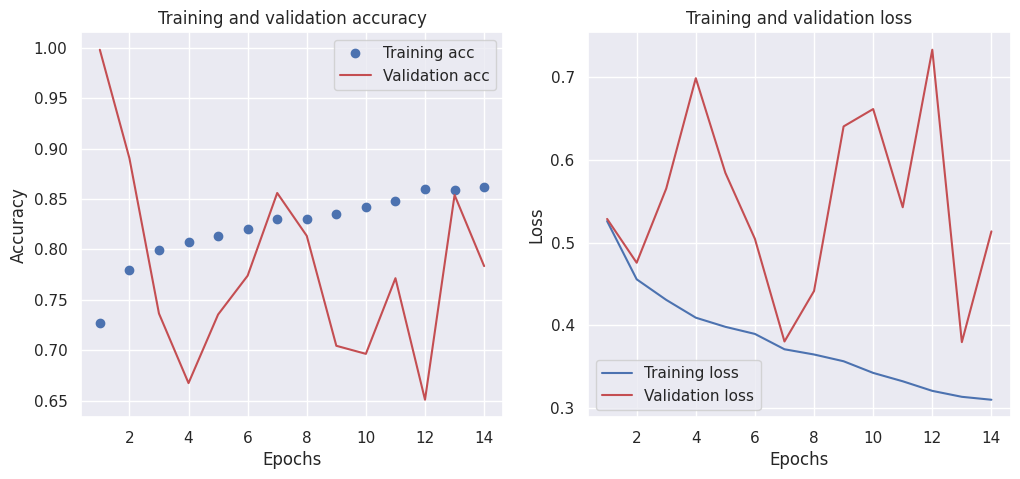

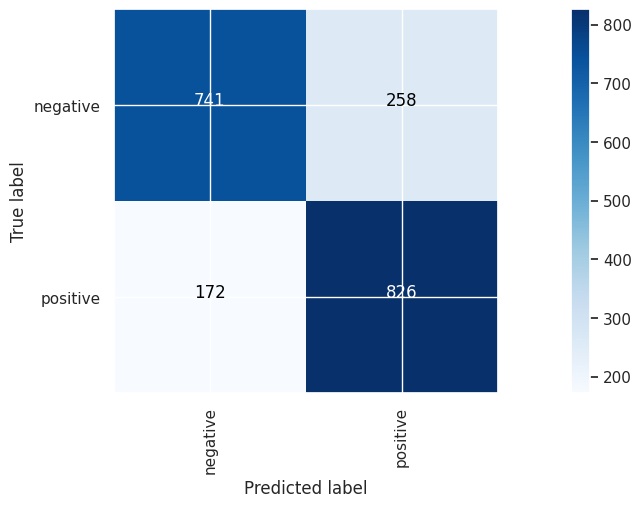

Final Accuracy
0.784677015523285
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_10 (Conv1D)          (None, 4997, 32)             160       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_11 (Ba  (None, 4997, 32)             128       ['conv1d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_12 (Ba  (None, 49

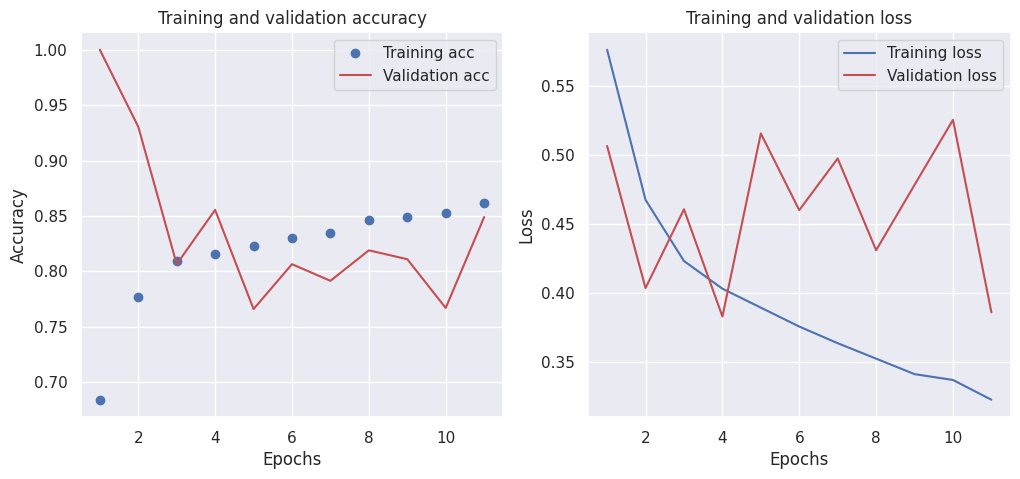

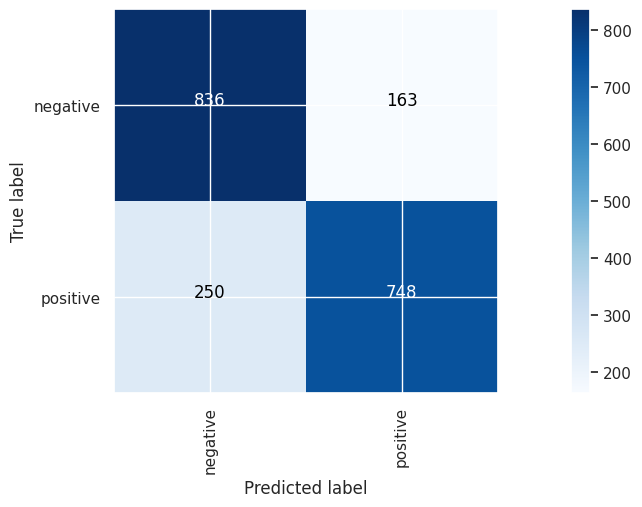

Final Accuracy
0.7931897846770155
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 600, 50)              1488650   ['input_7[0][0]']             
                                                                                                  
 conv1d_12 (Conv1D)          (None, 597, 32)              6432      ['embedding_1[0][0]']         
                                                                                                  
 batch_normalization_14 (Ba  (None, 597, 32)              128       ['conv1d_12[0][0]']           
 tchNormalization)                   

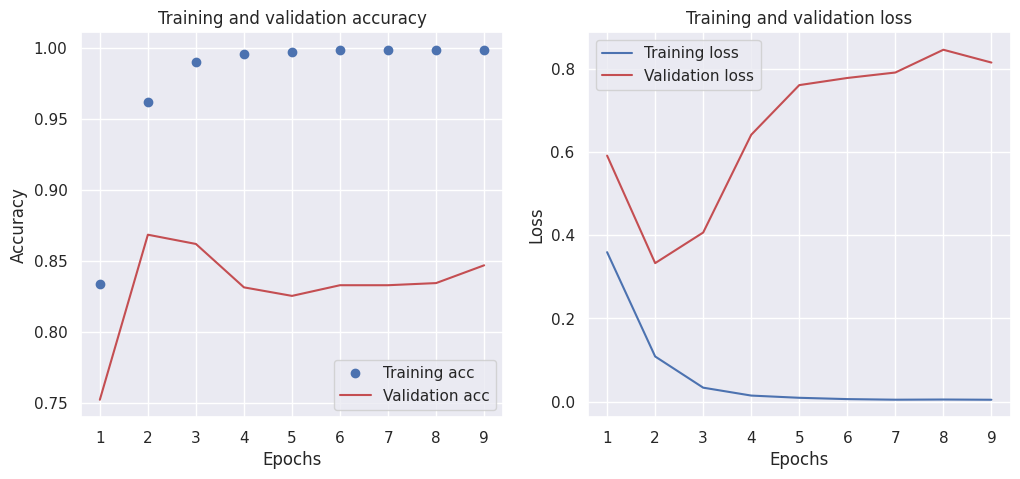

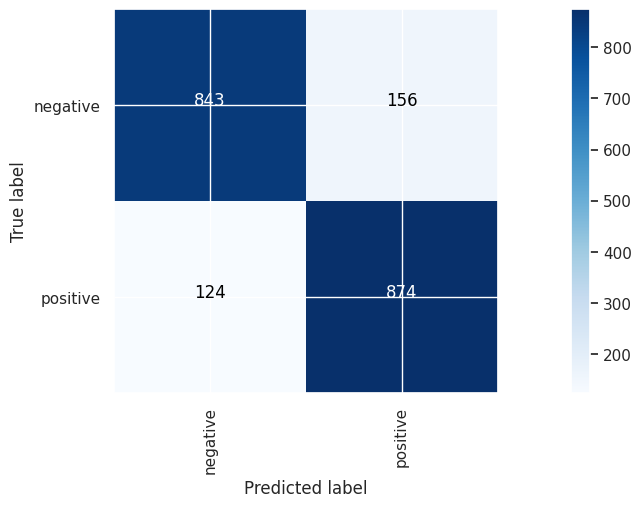

Final Accuracy
0.8597896845267902
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 600, 50)              1488650   ['input_8[0][0]']             
                                                                                                  
 conv1d_14 (Conv1D)          (None, 597, 32)              6432      ['embedding_2[0][0]']         
                                                                                                  
 batch_normalization_17 (Ba  (None, 597, 32)              128       ['conv1d_14[0][0]']           
 tchNormalization)                   

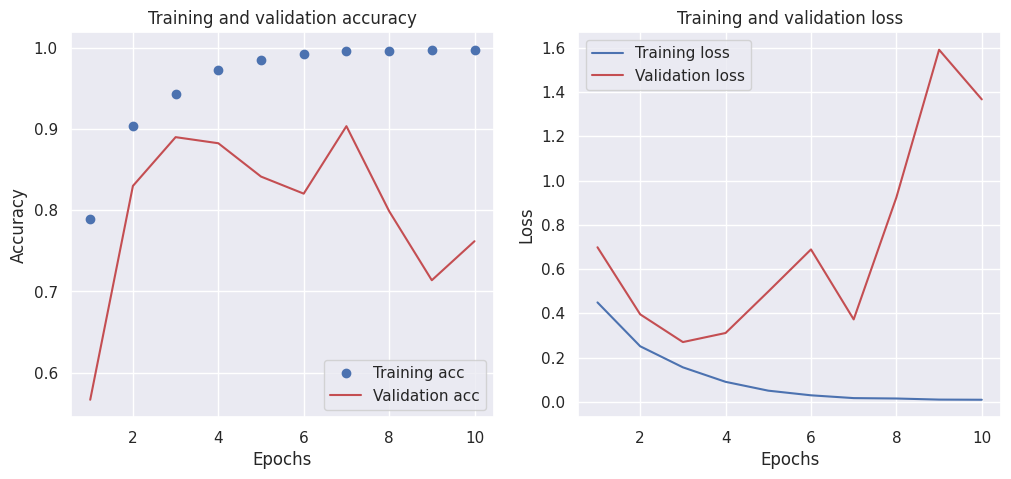

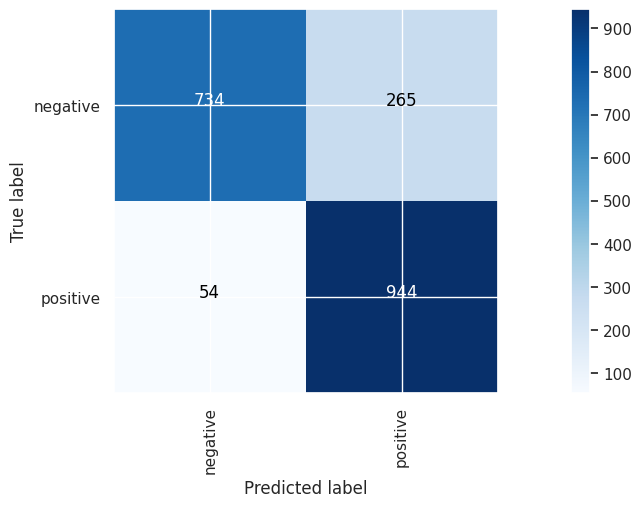

Final Accuracy
0.8402603905858789


In [8]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.0,
                general_dropout=0.0, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
block_dropout=0.0
general_dropout=0.0
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_1.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 4997, 32)             160       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 4997, 32)             128       ['conv1d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_21 (Ba  (None, 4997, 32)             128       ['c

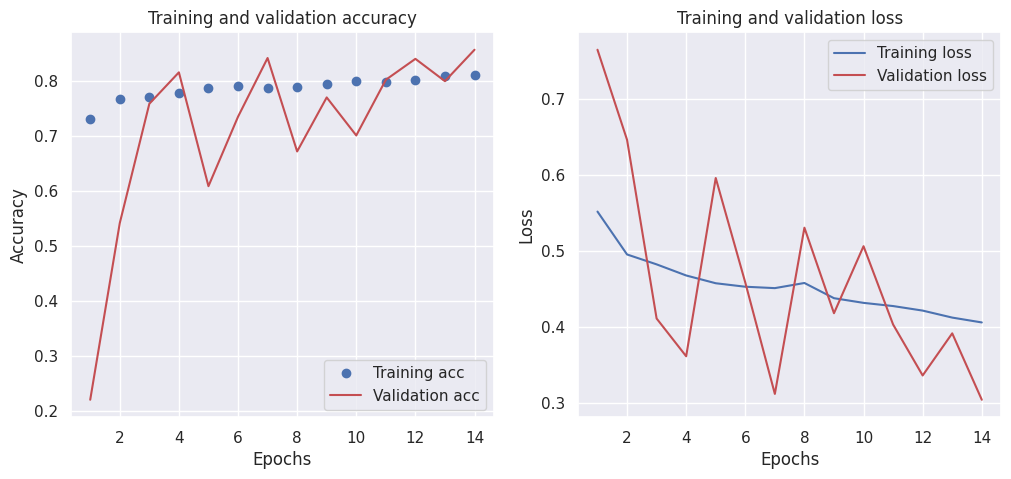

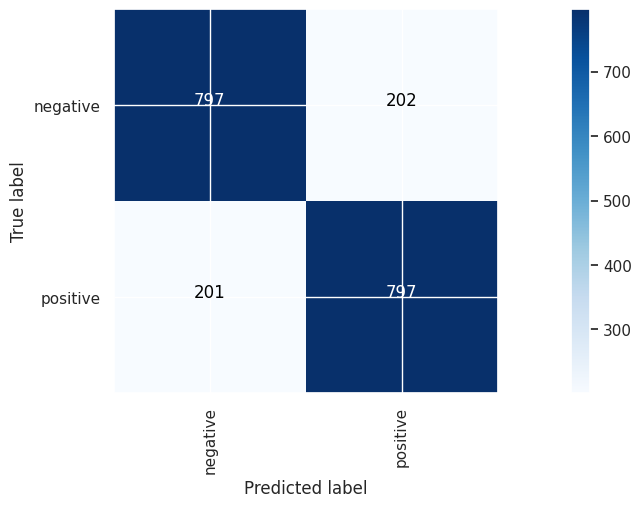

Final Accuracy
0.7981972959439159
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_18 (Conv1D)          (None, 4997, 32)             160       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_23 (Ba  (None, 4997, 32)             128       ['conv1d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_24 (Ba  (None, 4

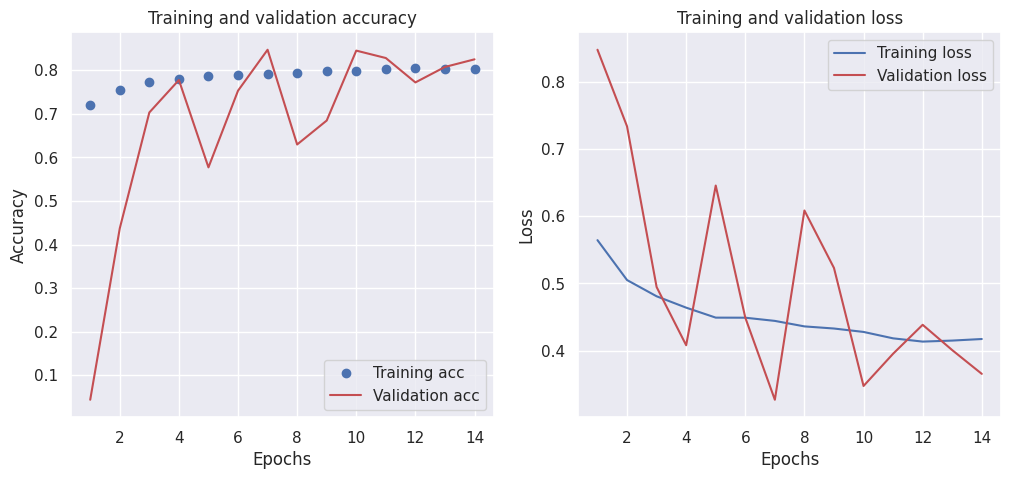

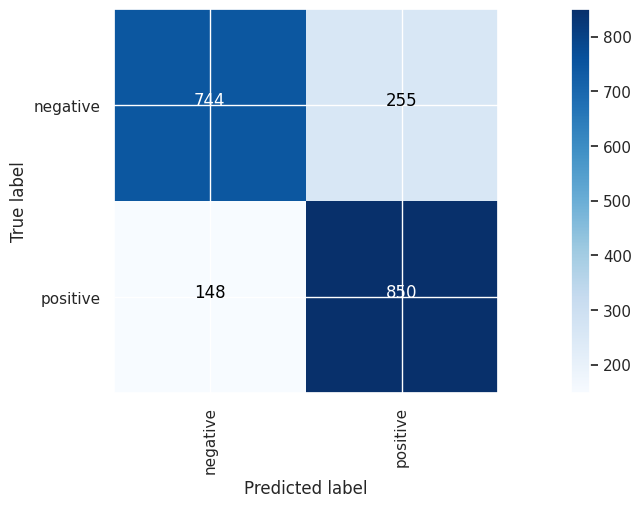

Final Accuracy
0.7981972959439159
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_20 (Conv1D)          (None, 4997, 32)             160       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_26 (Ba  (None, 4997, 32)             128       ['conv1d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_27 (Ba  (None, 4

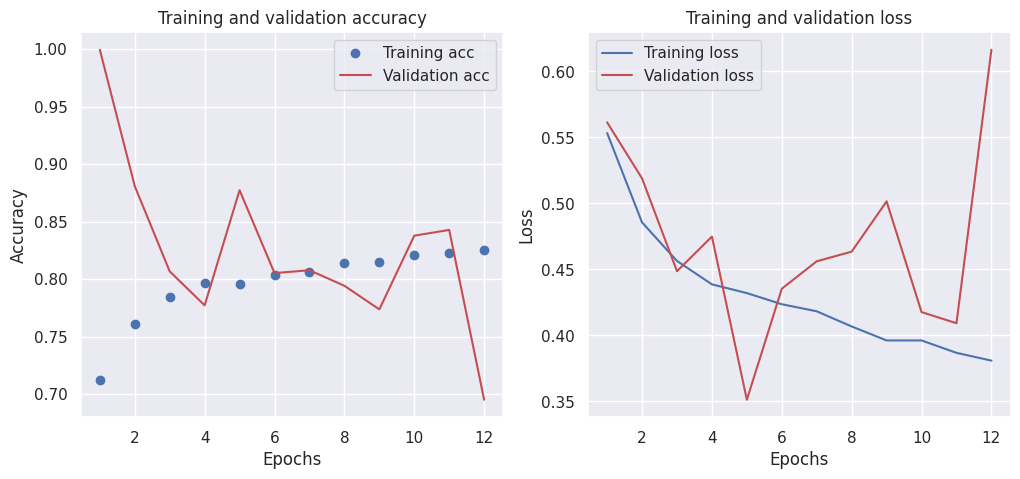

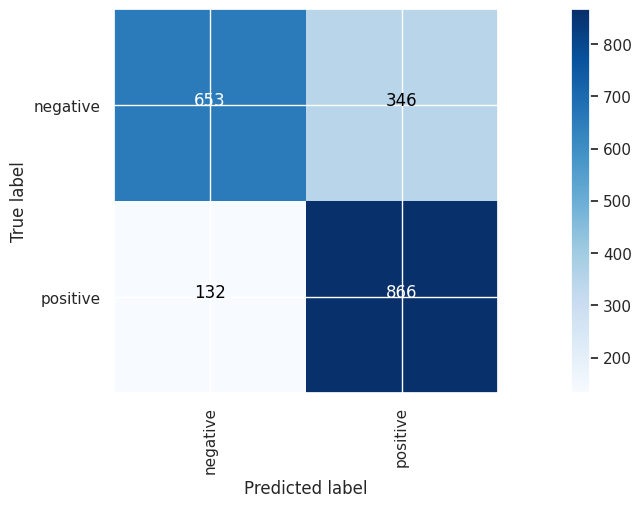

Final Accuracy
0.7606409614421632
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 4997, 32)             160       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_29 (Ba  (None, 4997, 32)             128       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_30 (Ba  (None, 4

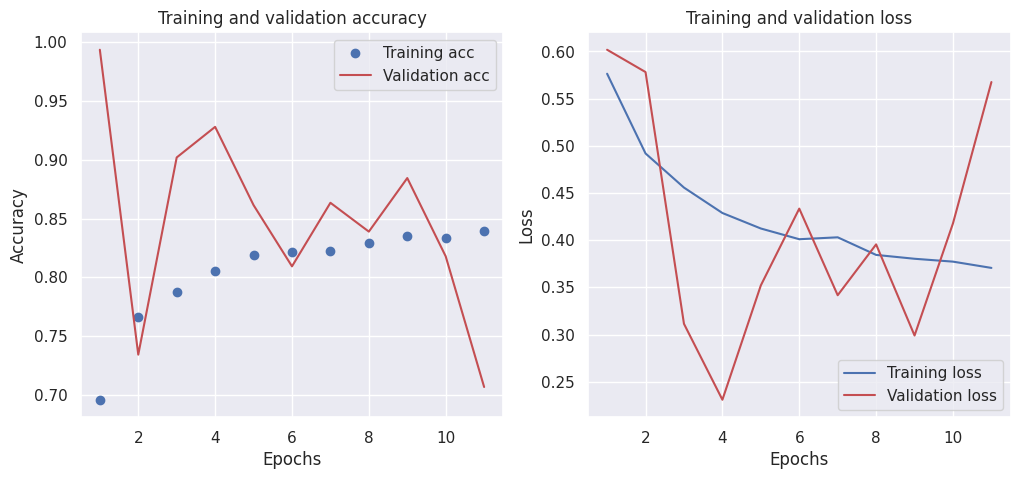

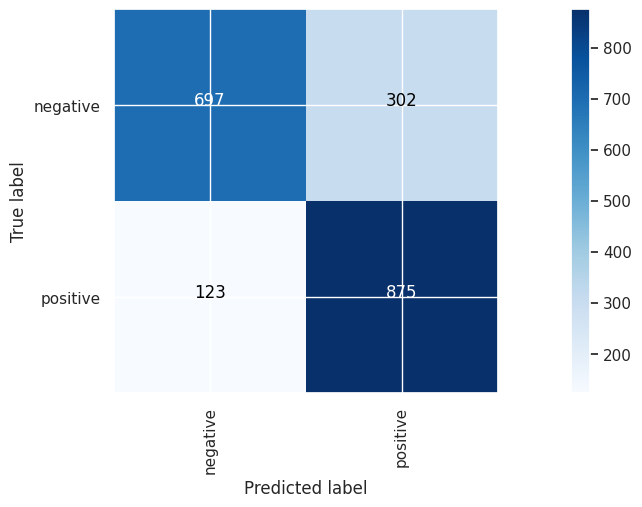

Final Accuracy
0.7871807711567351
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 600, 50)              1488650   ['input_13[0][0]']            
                                                                                                  
 conv1d_24 (Conv1D)          (None, 597, 32)              6432      ['embedding_3[0][0]']         
                                                                                                  
 batch_normalization_32 (Ba  (None, 597, 32)              128       ['conv1d_24[0][0]']           
 tchNormalization)                   

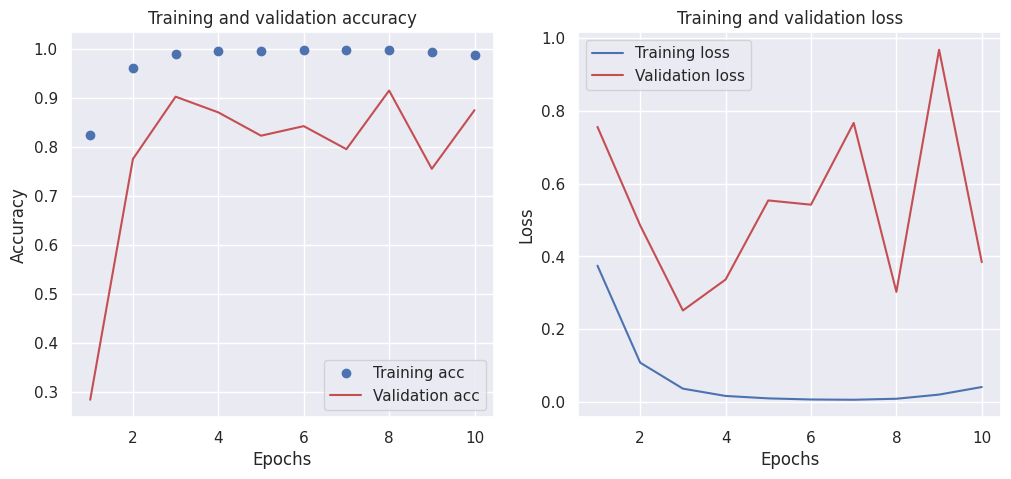

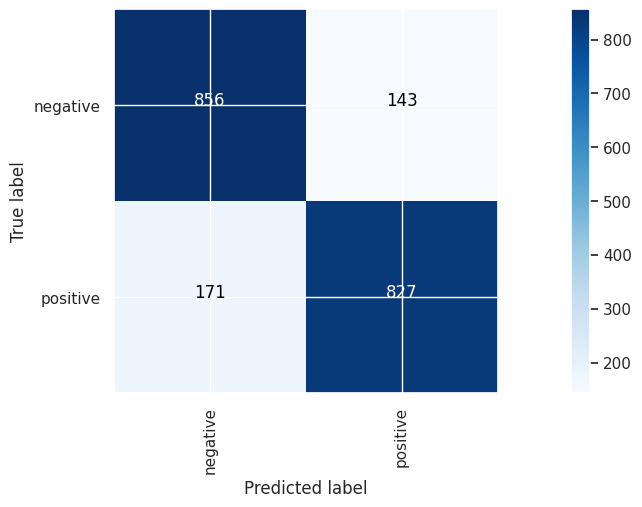

Final Accuracy
0.842764146219329
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 600, 50)              1488650   ['input_14[0][0]']            
                                                                                                  
 conv1d_26 (Conv1D)          (None, 597, 32)              6432      ['embedding_4[0][0]']         
                                                                                                  
 batch_normalization_35 (Ba  (None, 597, 32)              128       ['conv1d_26[0][0]']           
 tchNormalization)                    

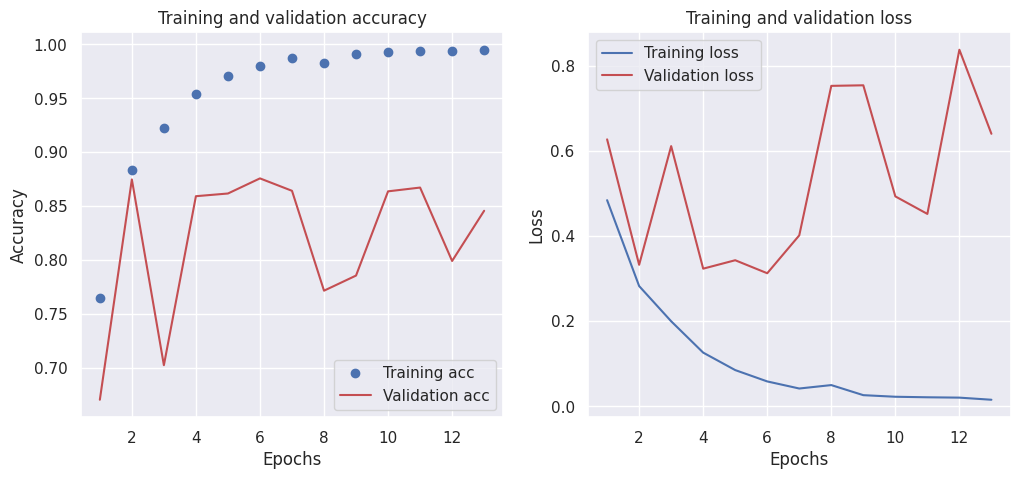

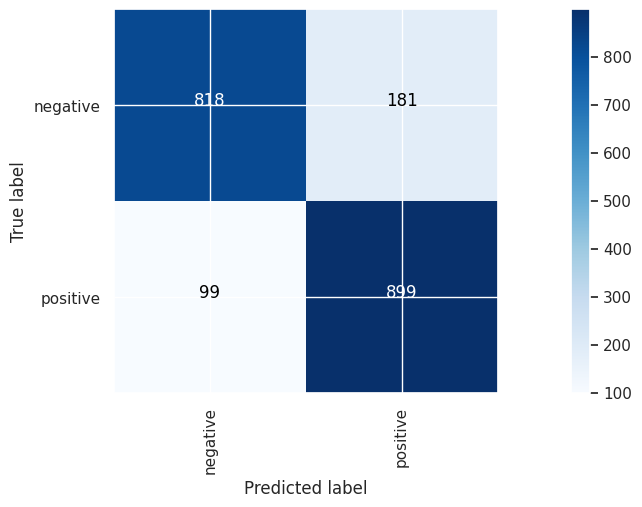

Final Accuracy
0.8597896845267902


In [9]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.0,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
block_dropout=0.0
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_2.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_28 (Conv1D)          (None, 4997, 32)             160       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_38 (Ba  (None, 4997, 32)             128       ['conv1d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_39 (Ba  (None, 4997, 32)             128       ['c

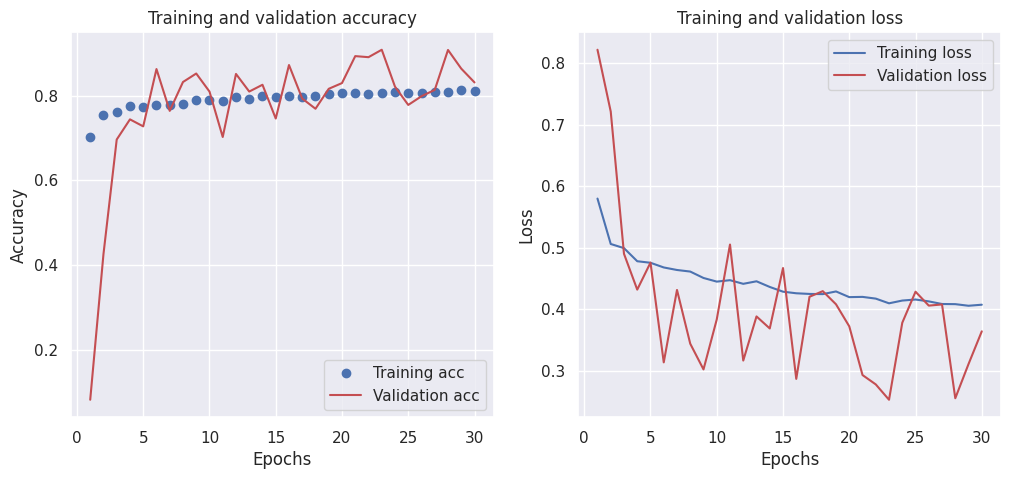

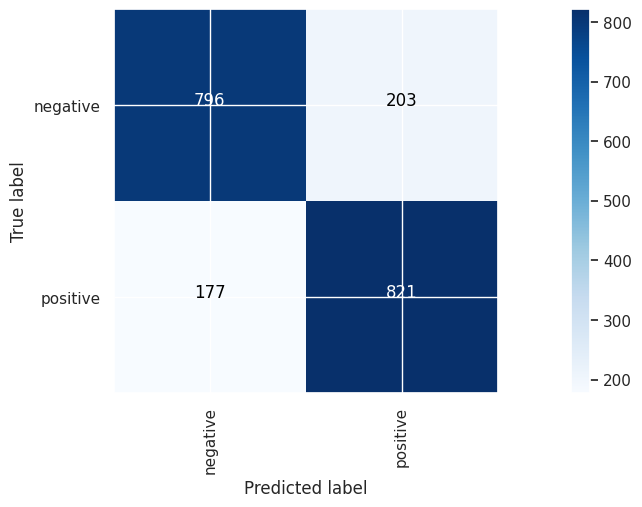

Final Accuracy
0.8097145718577867
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_30 (Conv1D)          (None, 4997, 32)             160       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_41 (Ba  (None, 4997, 32)             128       ['conv1d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_42 (Ba  (None, 4

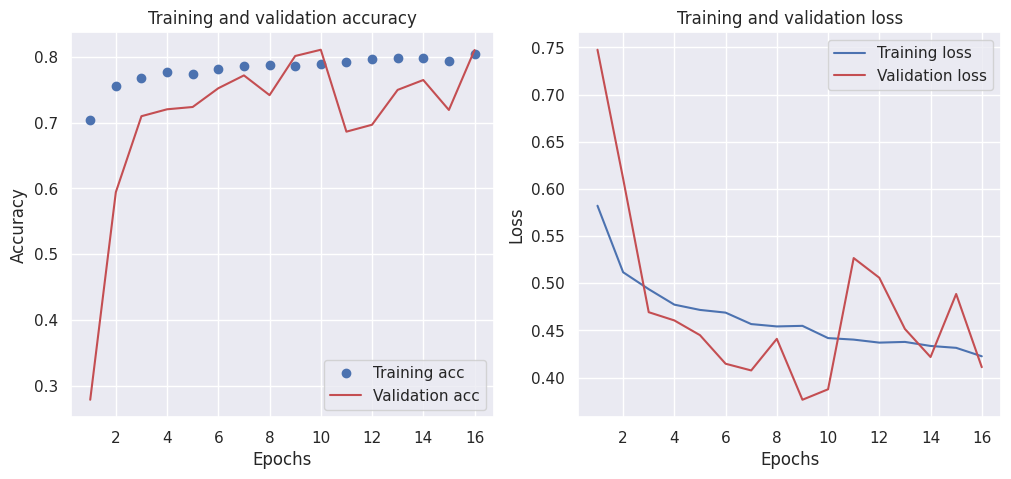

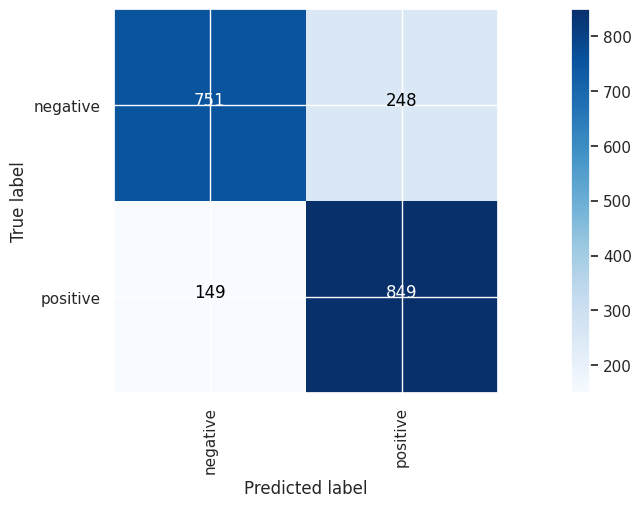

Final Accuracy
0.801201802704056
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_32 (Conv1D)          (None, 4997, 32)             160       ['input_17[0][0]']            
                                                                                                  
 batch_normalization_44 (Ba  (None, 4997, 32)             128       ['conv1d_32[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_45 (Ba  (None, 49

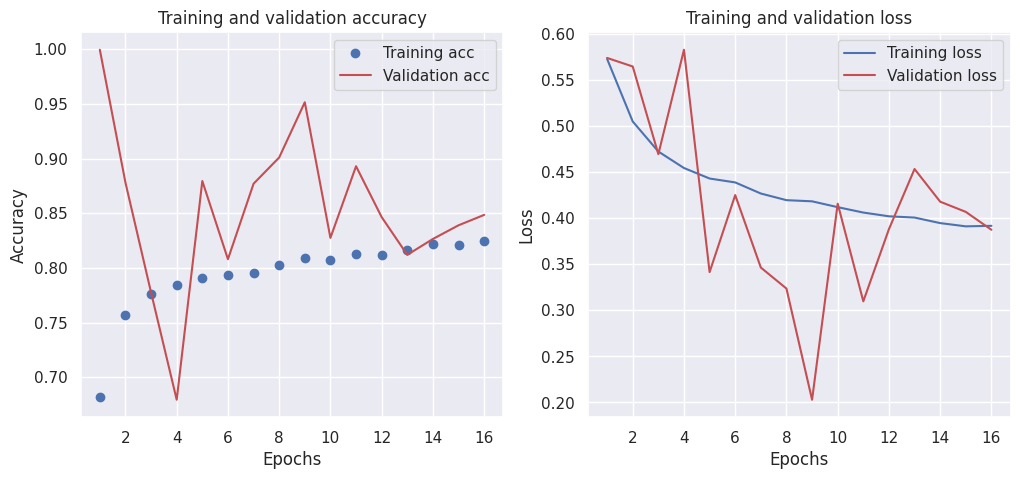

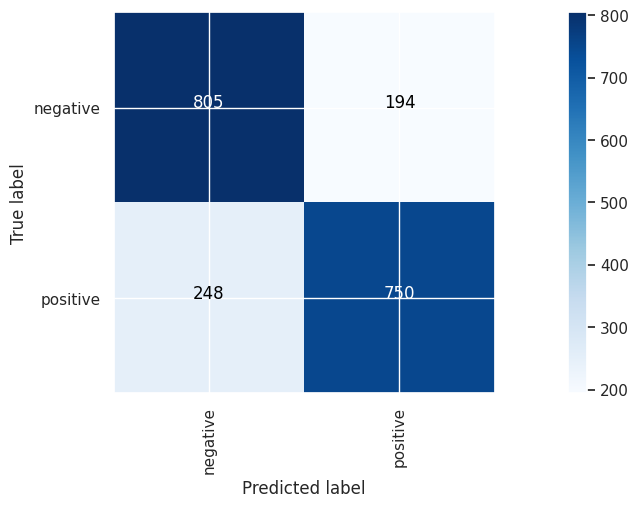

Final Accuracy
0.7786680020030045
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_34 (Conv1D)          (None, 4997, 32)             160       ['input_18[0][0]']            
                                                                                                  
 batch_normalization_47 (Ba  (None, 4997, 32)             128       ['conv1d_34[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_48 (Ba  (None, 4

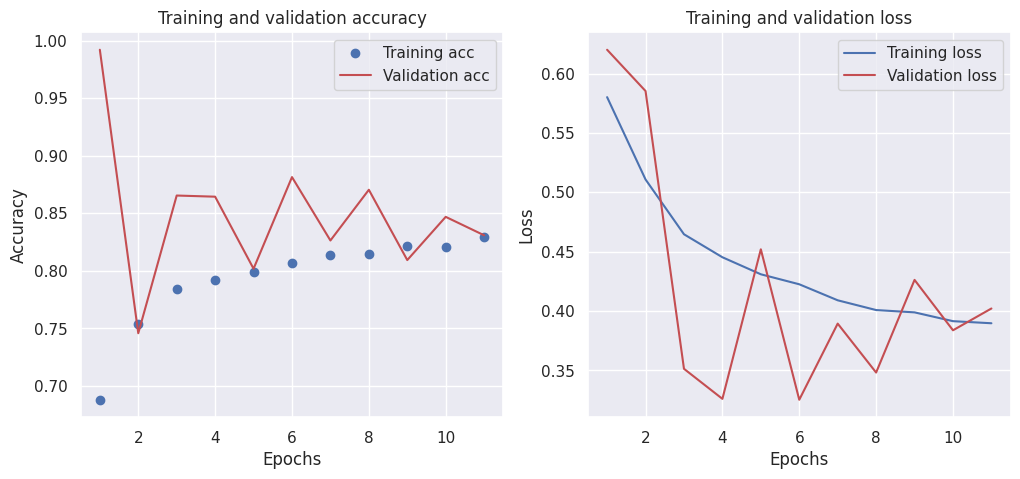

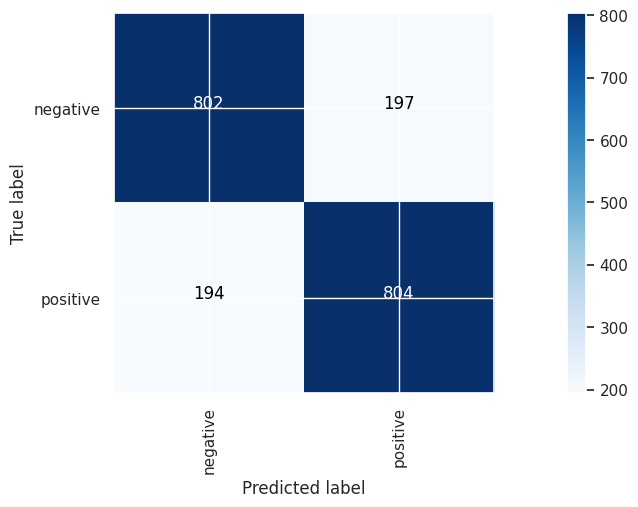

Final Accuracy
0.8042063094641962
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 600, 50)              1488650   ['input_19[0][0]']            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 597, 32)              6432      ['embedding_5[0][0]']         
                                                                                                  
 batch_normalization_50 (Ba  (None, 597, 32)              128       ['conv1d_36[0][0]']           
 tchNormalization)                   

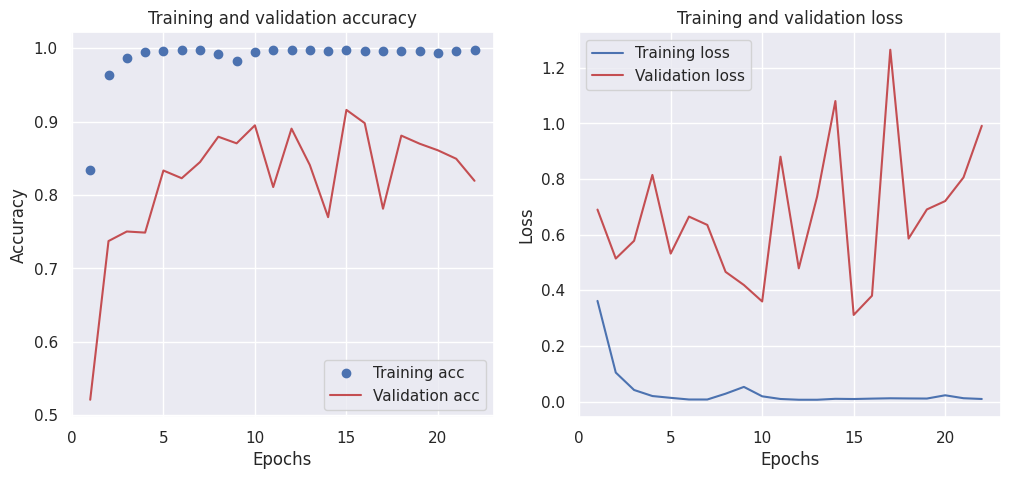

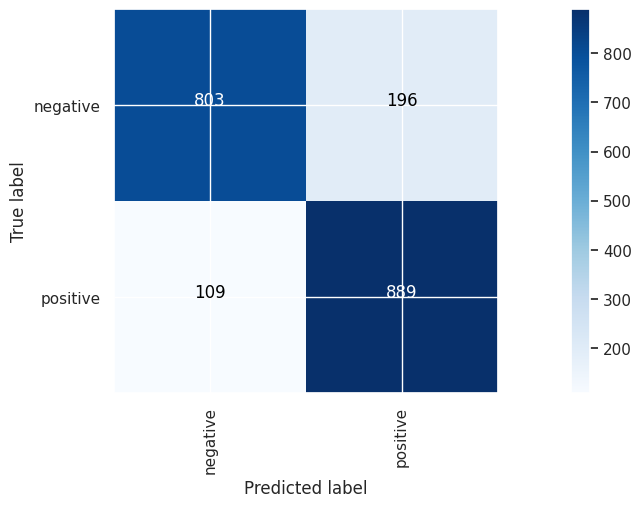

Final Accuracy
0.8472709063595393
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 600, 50)              1488650   ['input_20[0][0]']            
                                                                                                  
 conv1d_38 (Conv1D)          (None, 597, 32)              6432      ['embedding_6[0][0]']         
                                                                                                  
 batch_normalization_53 (Ba  (None, 597, 32)              128       ['conv1d_38[0][0]']           
 tchNormalization)                   

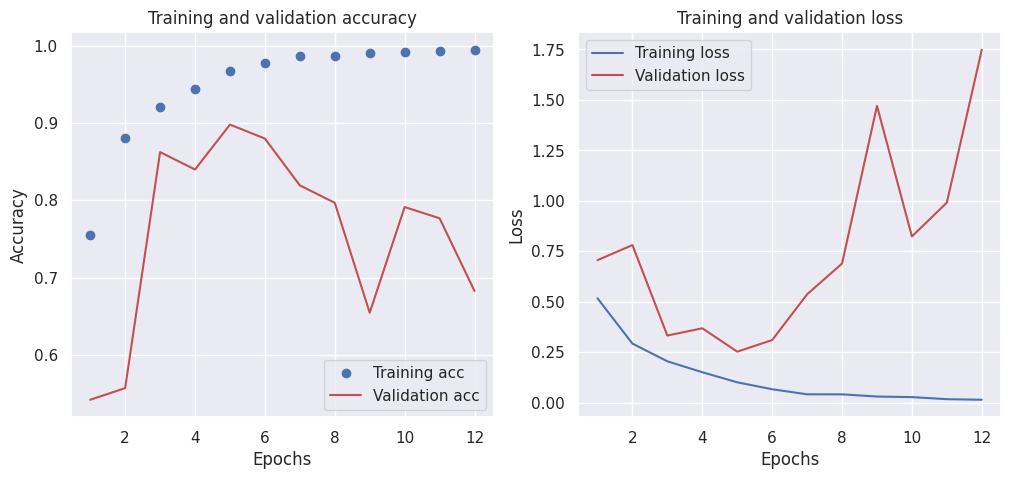

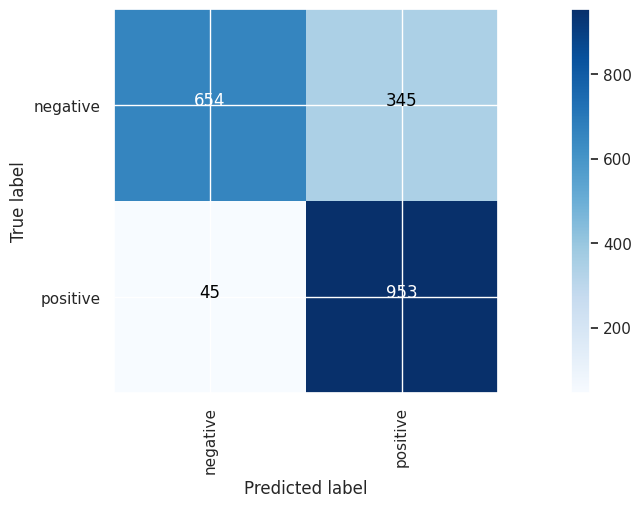

Final Accuracy
0.8047070605908864


In [10]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.15,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128]
kernel_size=4
dense_neurons=0
block_dropout=0.15
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_3.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_40 (Conv1D)          (None, 4997, 32)             160       ['input_21[0][0]']            
                                                                                                  
 batch_normalization_56 (Ba  (None, 4997, 32)             128       ['conv1d_40[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_57 (Ba  (None, 4997, 32)             128       ['c

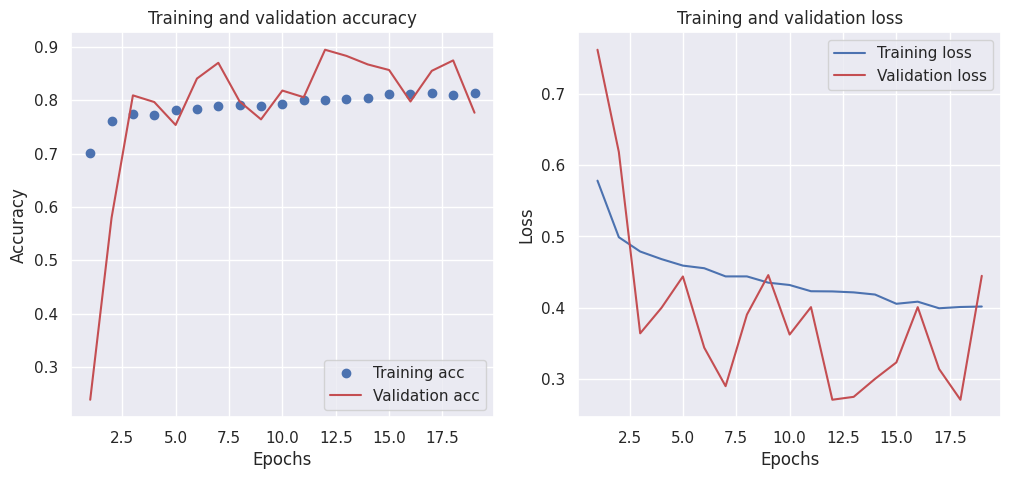

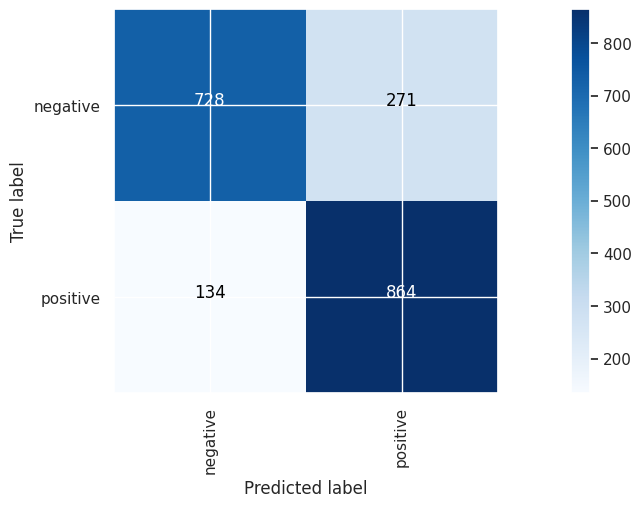

Final Accuracy
0.7971957936905358
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 4997, 32)             160       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_60 (Ba  (None, 4997, 32)             128       ['conv1d_42[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_61 (Ba  (None, 4

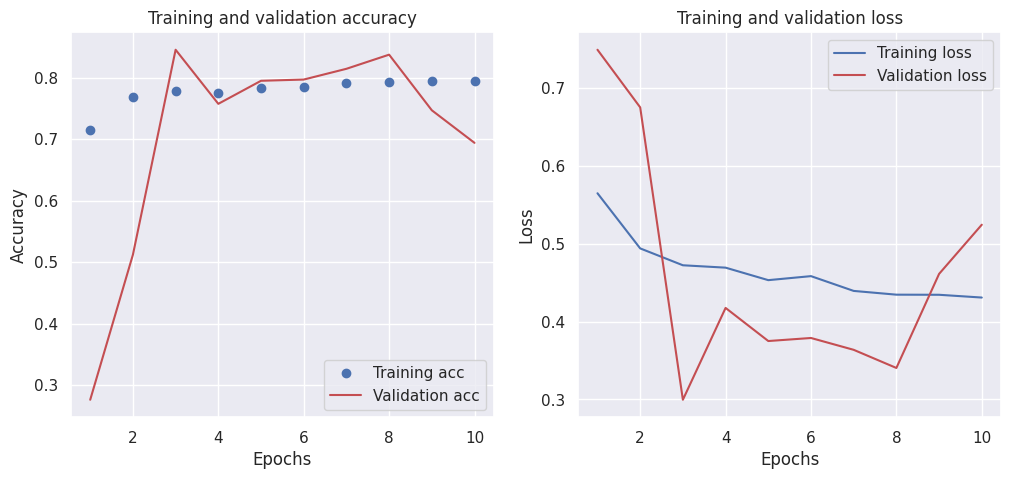

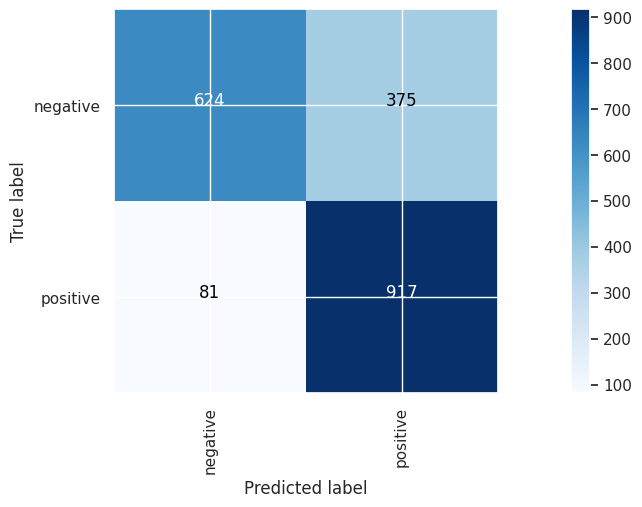

Final Accuracy
0.771657486229344
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_44 (Conv1D)          (None, 4997, 32)             160       ['input_23[0][0]']            
                                                                                                  
 batch_normalization_64 (Ba  (None, 4997, 32)             128       ['conv1d_44[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_65 (Ba  (None, 49

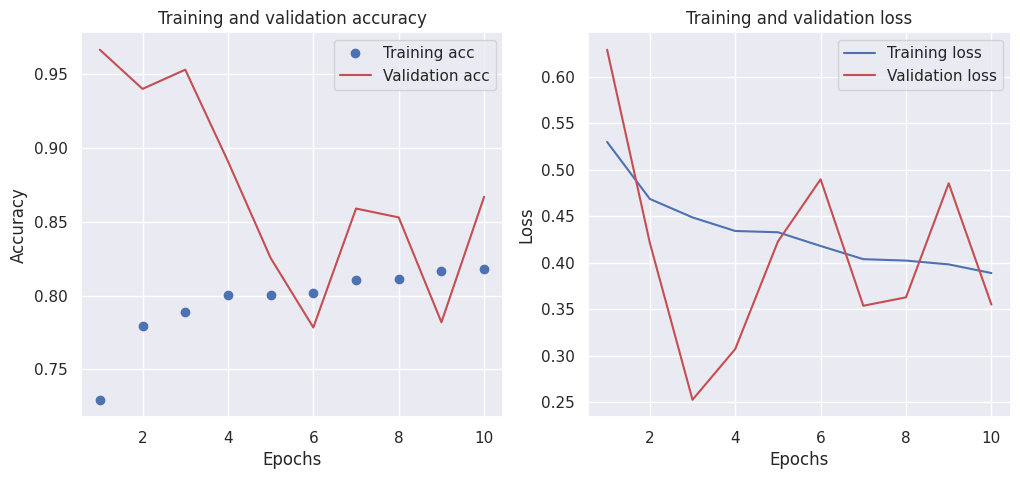

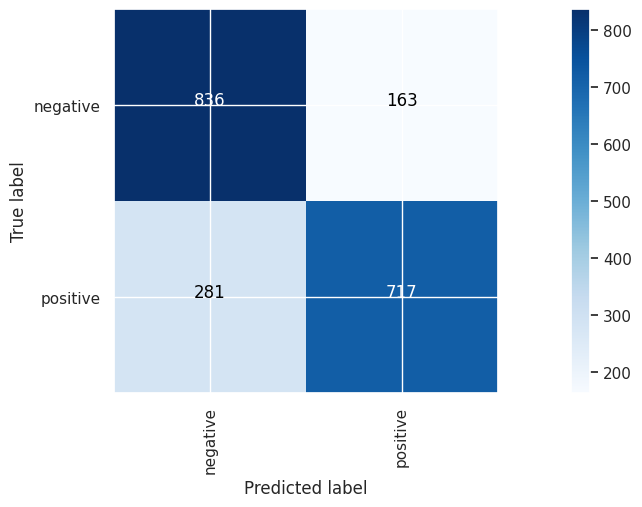

Final Accuracy
0.7776664997496244
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_46 (Conv1D)          (None, 4997, 32)             160       ['input_24[0][0]']            
                                                                                                  
 batch_normalization_68 (Ba  (None, 4997, 32)             128       ['conv1d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_69 (Ba  (None, 4

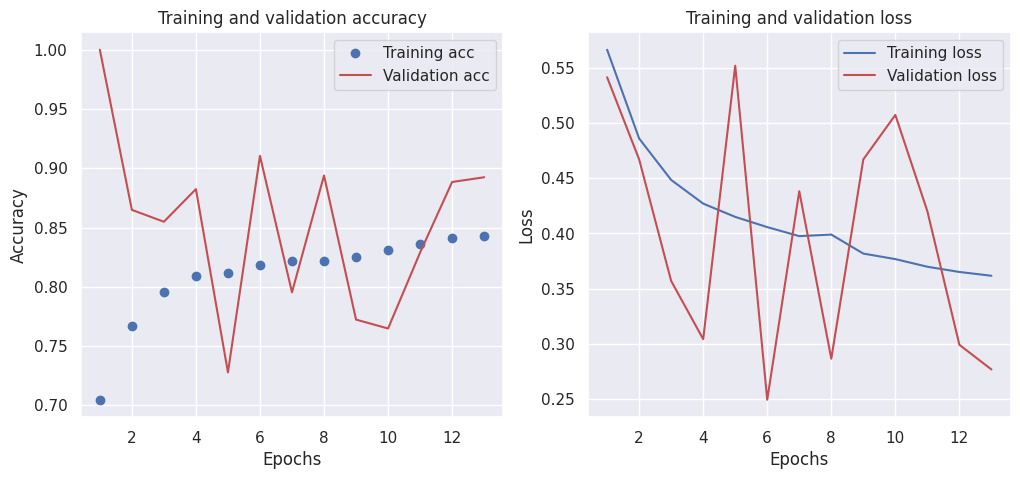

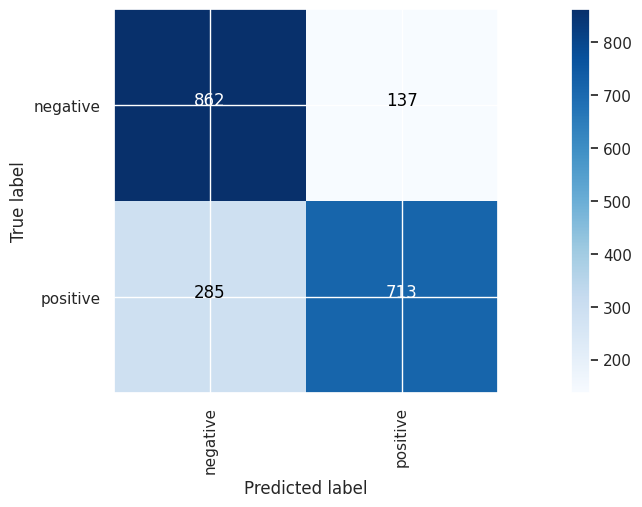

Final Accuracy
0.7886830245368052
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 600, 50)              1488650   ['input_25[0][0]']            
                                                                                                  
 conv1d_48 (Conv1D)          (None, 597, 32)              6432      ['embedding_7[0][0]']         
                                                                                                  
 batch_normalization_72 (Ba  (None, 597, 32)              128       ['conv1d_48[0][0]']           
 tchNormalization)                   

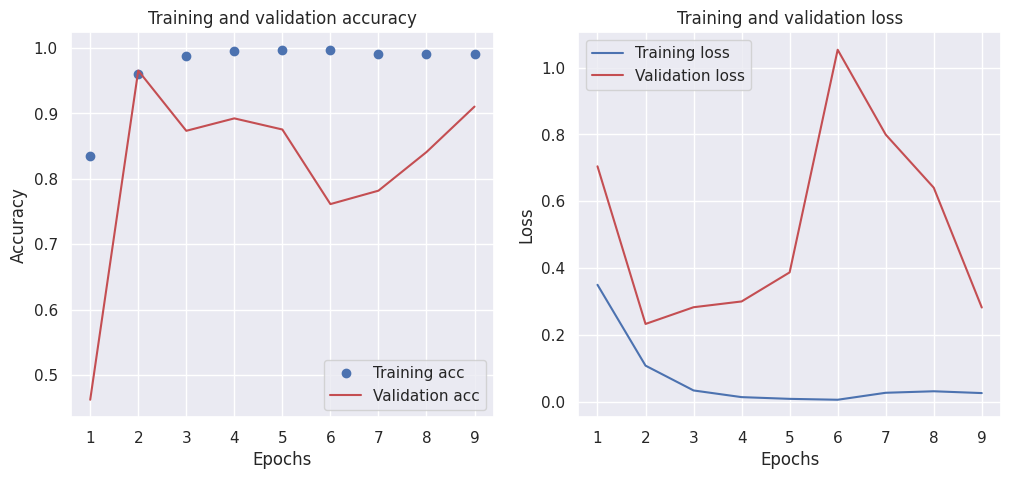

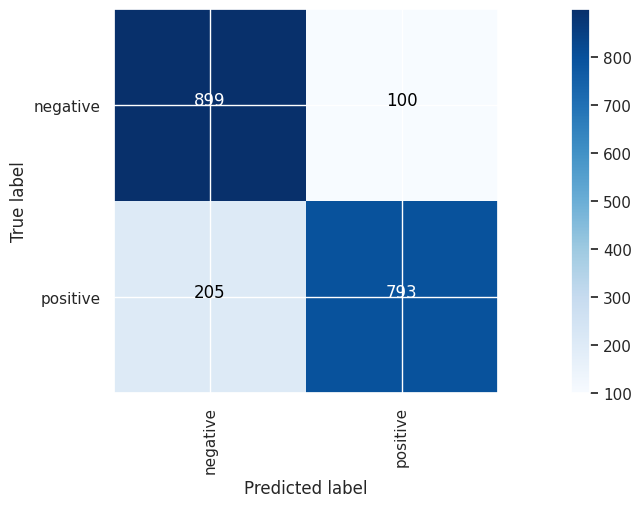

Final Accuracy
0.8472709063595393
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 600, 50)              1488650   ['input_26[0][0]']            
                                                                                                  
 conv1d_50 (Conv1D)          (None, 597, 32)              6432      ['embedding_8[0][0]']         
                                                                                                  
 batch_normalization_76 (Ba  (None, 597, 32)              128       ['conv1d_50[0][0]']           
 tchNormalization)                   

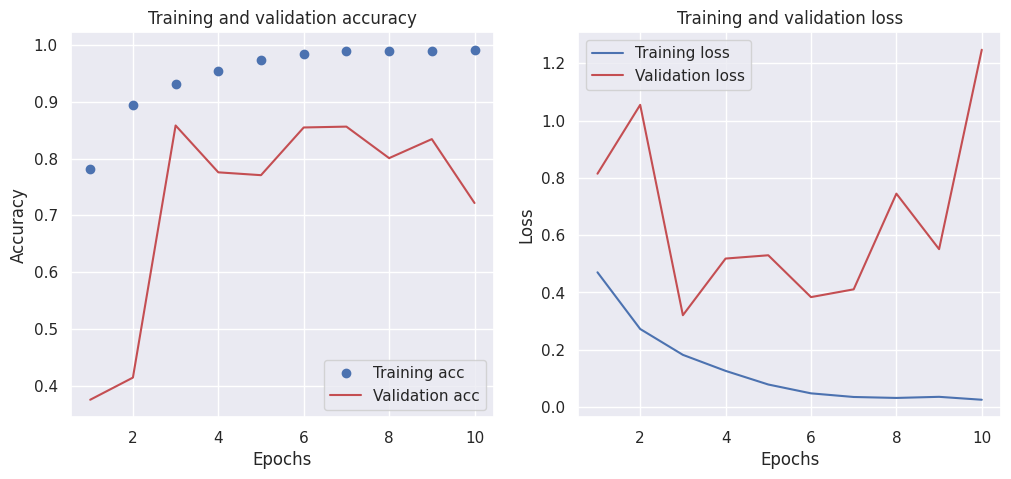

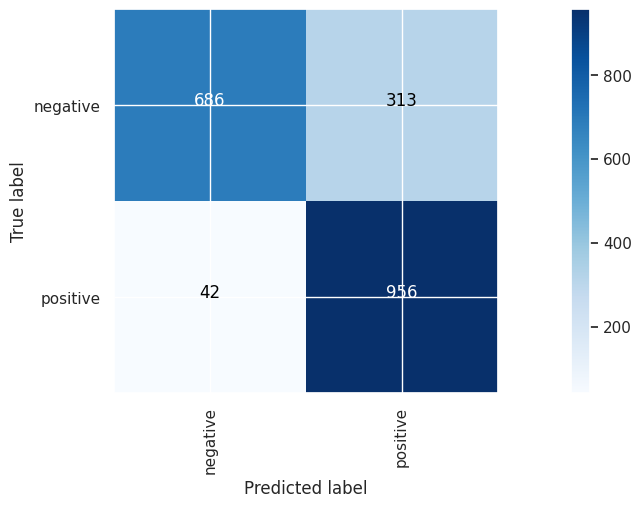

Final Accuracy
0.8222333500250375


In [11]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64,128,256],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.15,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64,128,256]
kernel_size=4
dense_neurons=0
block_dropout=0.15
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_4.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_52 (Conv1D)          (None, 4997, 32)             160       ['input_27[0][0]']            
                                                                                                  
 batch_normalization_80 (Ba  (None, 4997, 32)             128       ['conv1d_52[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_81 (Ba  (None, 4997, 32)             128       ['c

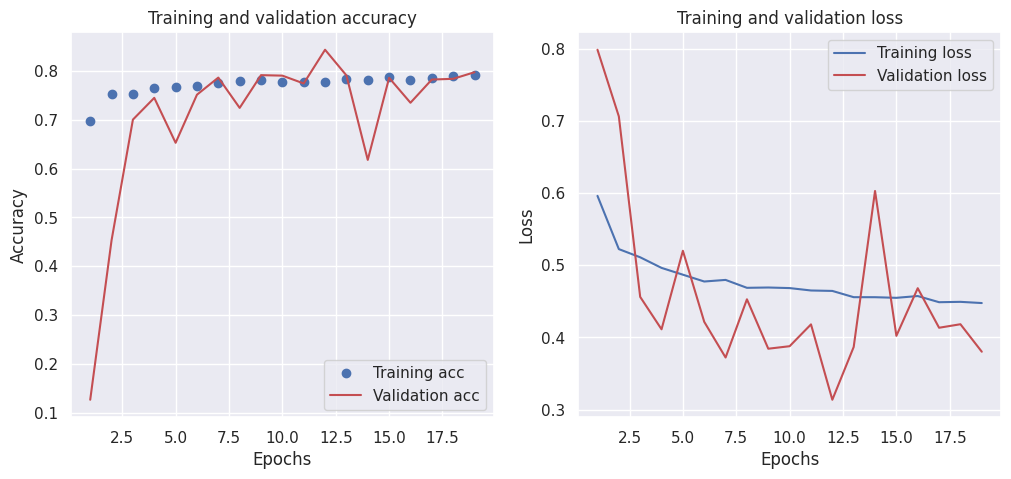

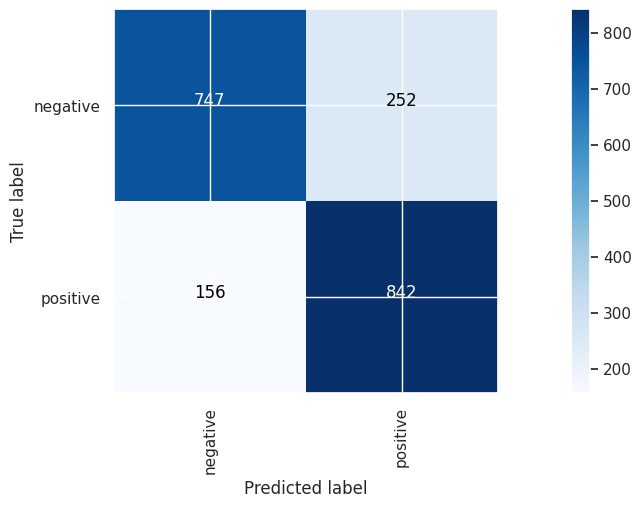

Final Accuracy
0.7956935403104657
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_54 (Conv1D)          (None, 4997, 32)             160       ['input_28[0][0]']            
                                                                                                  
 batch_normalization_82 (Ba  (None, 4997, 32)             128       ['conv1d_54[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_83 (Ba  (None, 4

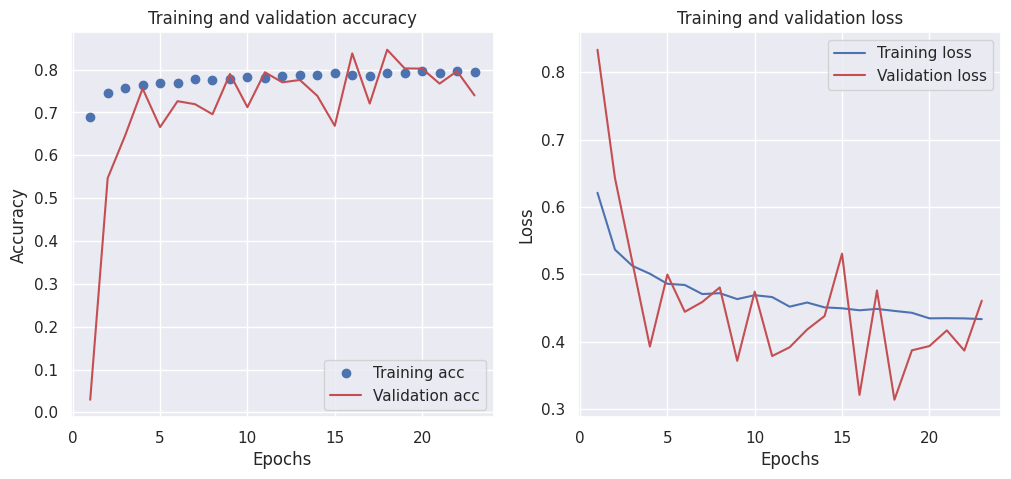

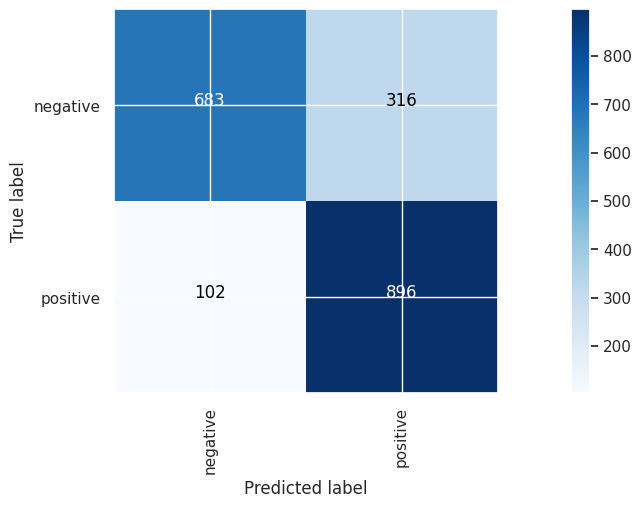

Final Accuracy
0.7906860290435653
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_56 (Conv1D)          (None, 4997, 32)             160       ['input_29[0][0]']            
                                                                                                  
 batch_normalization_84 (Ba  (None, 4997, 32)             128       ['conv1d_56[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_85 (Ba  (None, 4

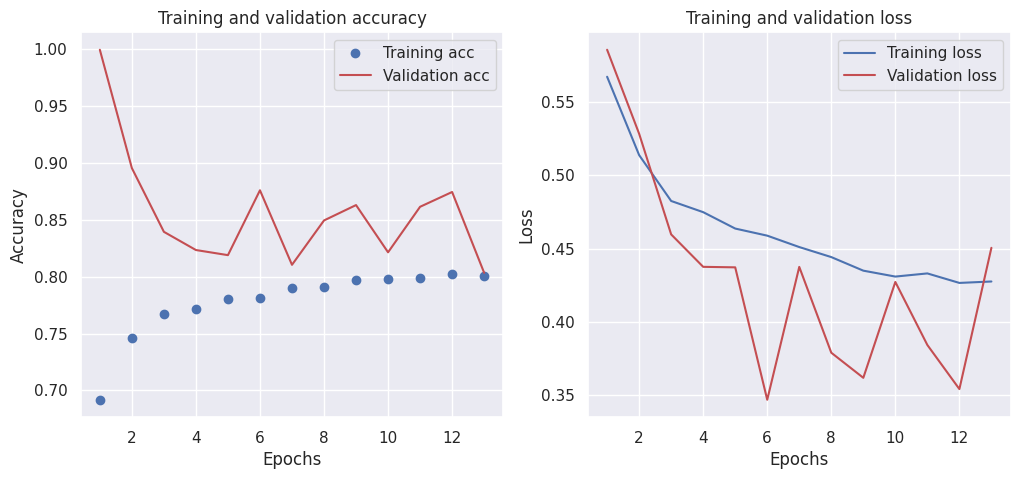

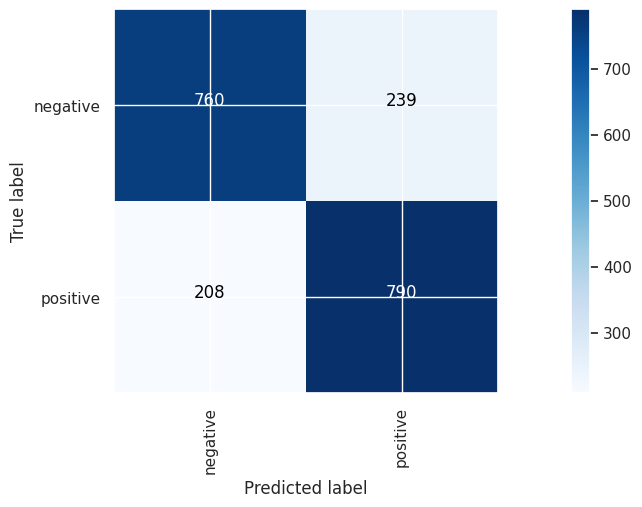

Final Accuracy
0.7761642463695543
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_58 (Conv1D)          (None, 4997, 32)             160       ['input_30[0][0]']            
                                                                                                  
 batch_normalization_86 (Ba  (None, 4997, 32)             128       ['conv1d_58[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_87 (Ba  (None, 4

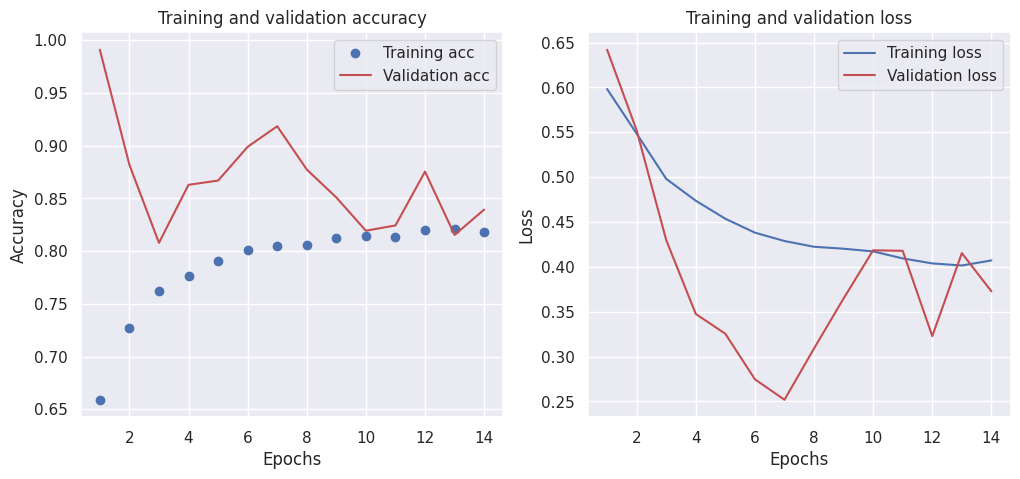

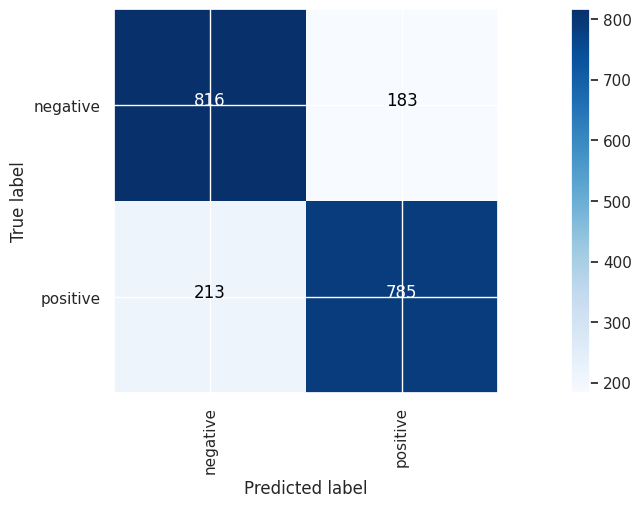

Final Accuracy
0.8017025538307461
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 600, 50)              1488650   ['input_31[0][0]']            
                                                                                                  
 conv1d_60 (Conv1D)          (None, 597, 32)              6432      ['embedding_9[0][0]']         
                                                                                                  
 batch_normalization_88 (Ba  (None, 597, 32)              128       ['conv1d_60[0][0]']           
 tchNormalization)                   

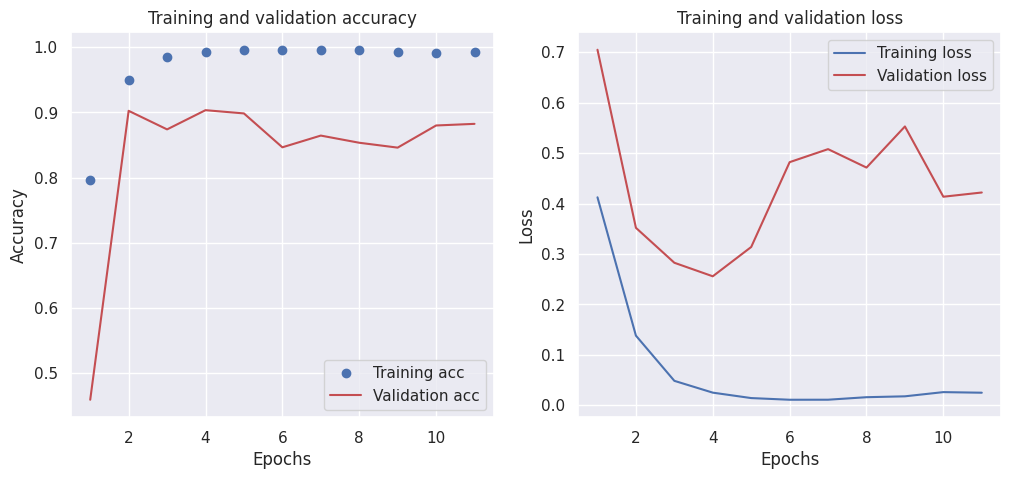

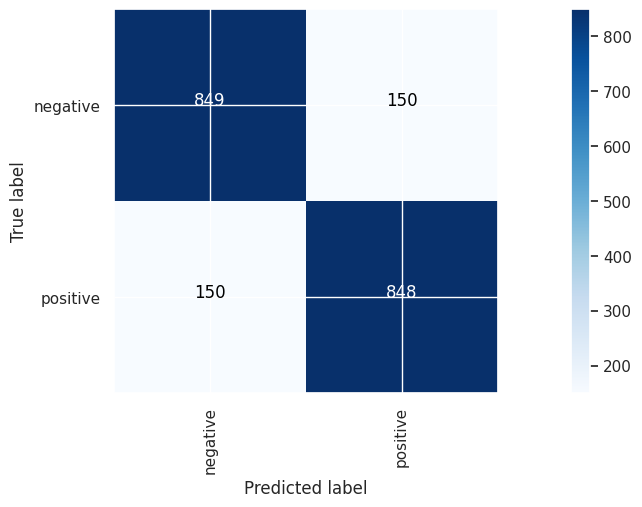

Final Accuracy
0.8497746619929895
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, 600, 50)              1488650   ['input_32[0][0]']            
                                                                                                  
 conv1d_62 (Conv1D)          (None, 597, 32)              6432      ['embedding_10[0][0]']        
                                                                                                  
 batch_normalization_90 (Ba  (None, 597, 32)              128       ['conv1d_62[0][0]']           
 tchNormalization)                   

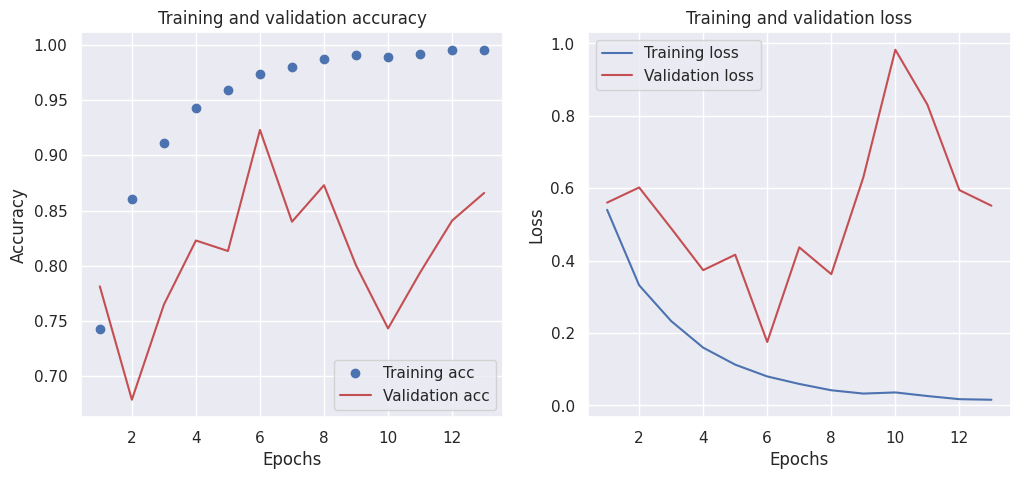

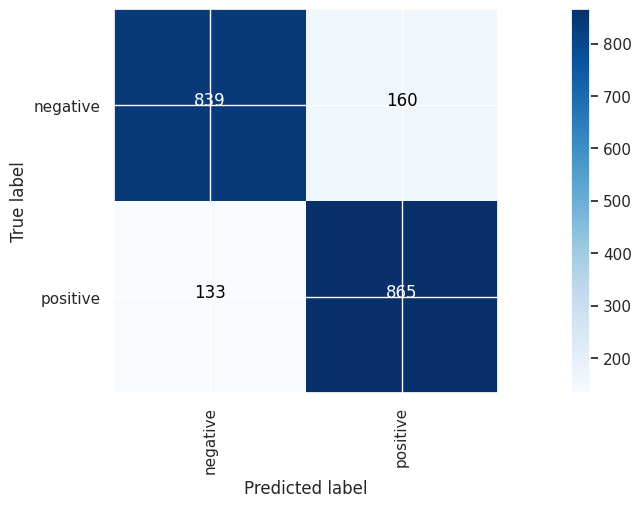

Final Accuracy
0.8532799198798198


In [12]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[32,64],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.15,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[32,64]
kernel_size=4
dense_neurons=0
block_dropout=0.15
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_5.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_64 (Conv1D)          (None, 4997, 64)             320       ['input_33[0][0]']            
                                                                                                  
 batch_normalization_92 (Ba  (None, 4997, 64)             256       ['conv1d_64[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_93 (Ba  (None, 4997, 64)             256       ['c

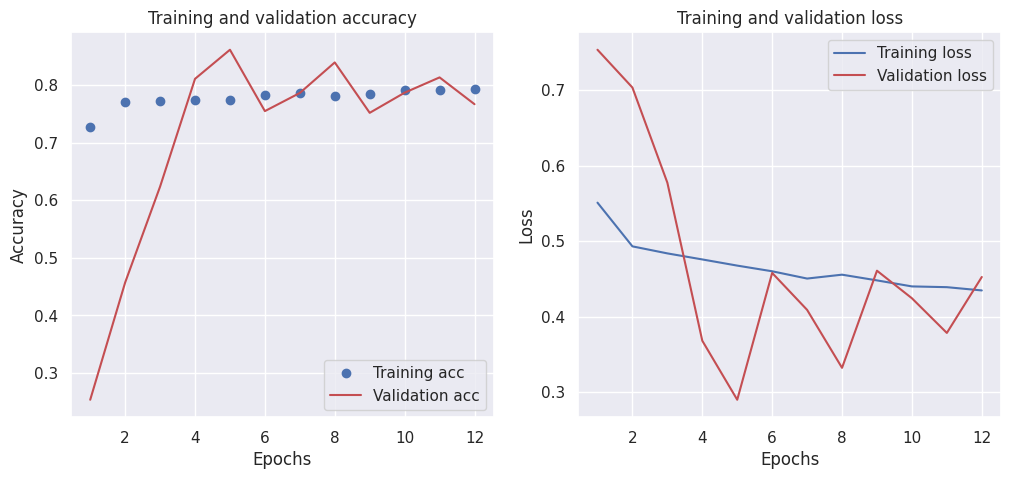

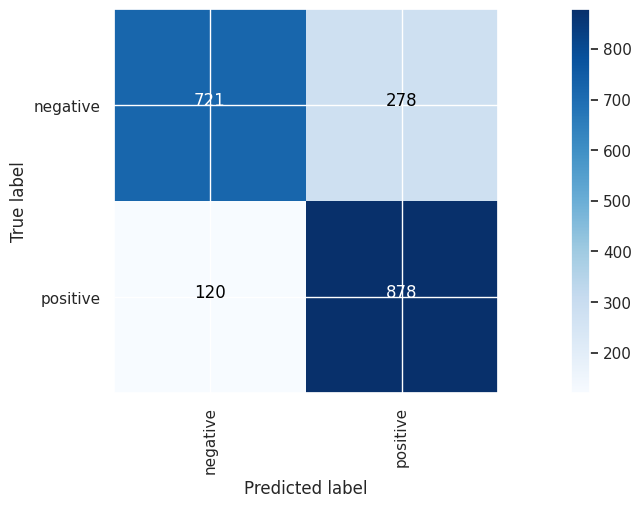

Final Accuracy
0.800701051577366
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_66 (Conv1D)          (None, 4997, 64)             320       ['input_34[0][0]']            
                                                                                                  
 batch_normalization_94 (Ba  (None, 4997, 64)             256       ['conv1d_66[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_95 (Ba  (None, 49

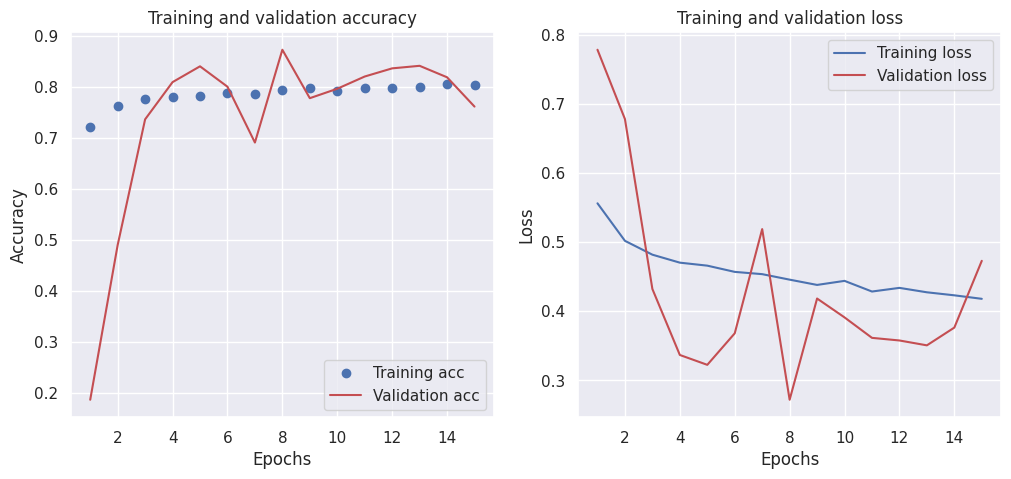

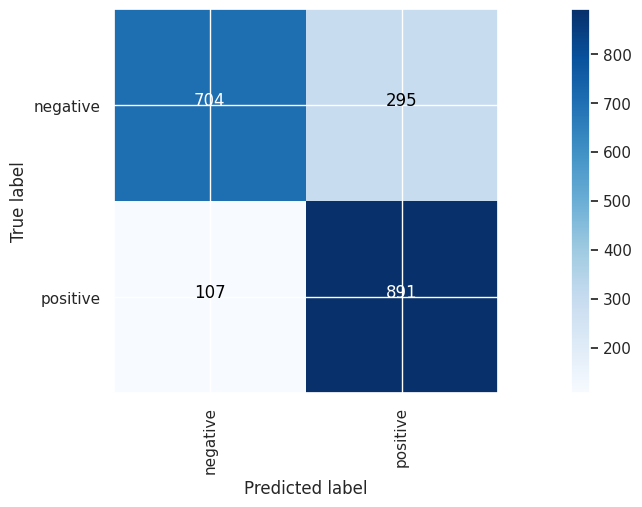

Final Accuracy
0.7986980470706059
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_68 (Conv1D)          (None, 4997, 64)             320       ['input_35[0][0]']            
                                                                                                  
 batch_normalization_96 (Ba  (None, 4997, 64)             256       ['conv1d_68[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_97 (Ba  (None, 4

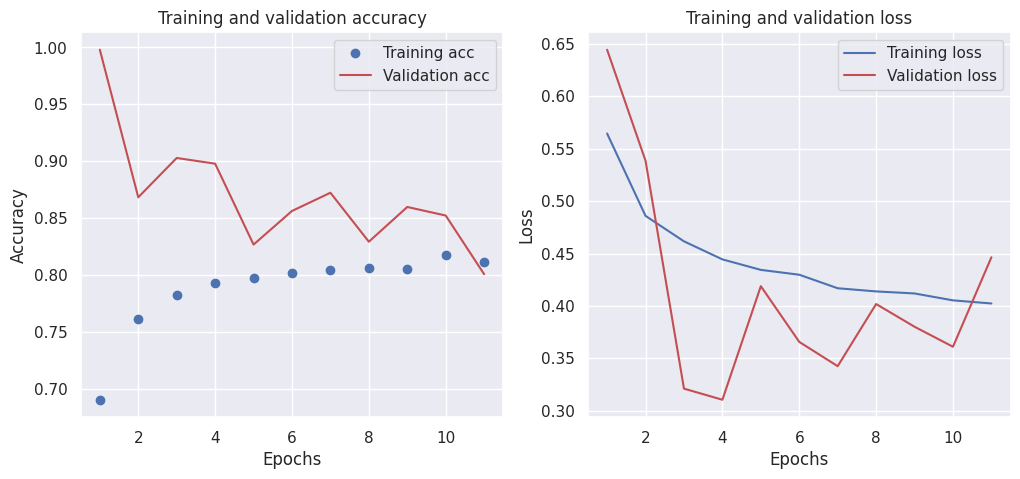

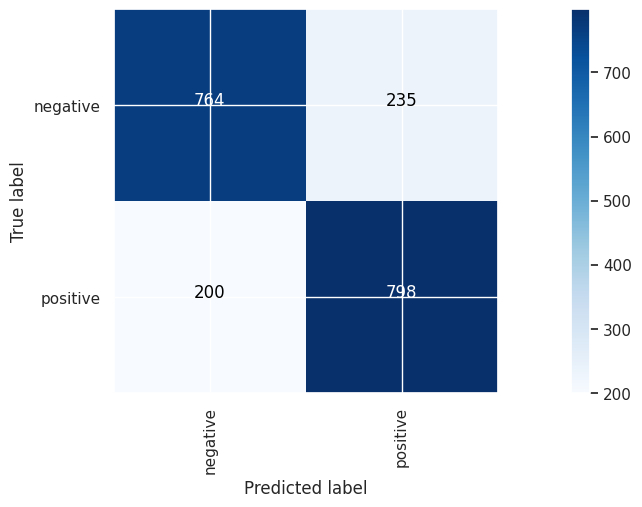

Final Accuracy
0.7821732598898348
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_70 (Conv1D)          (None, 4997, 64)             320       ['input_36[0][0]']            
                                                                                                  
 batch_normalization_98 (Ba  (None, 4997, 64)             256       ['conv1d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_99 (Ba  (None, 4

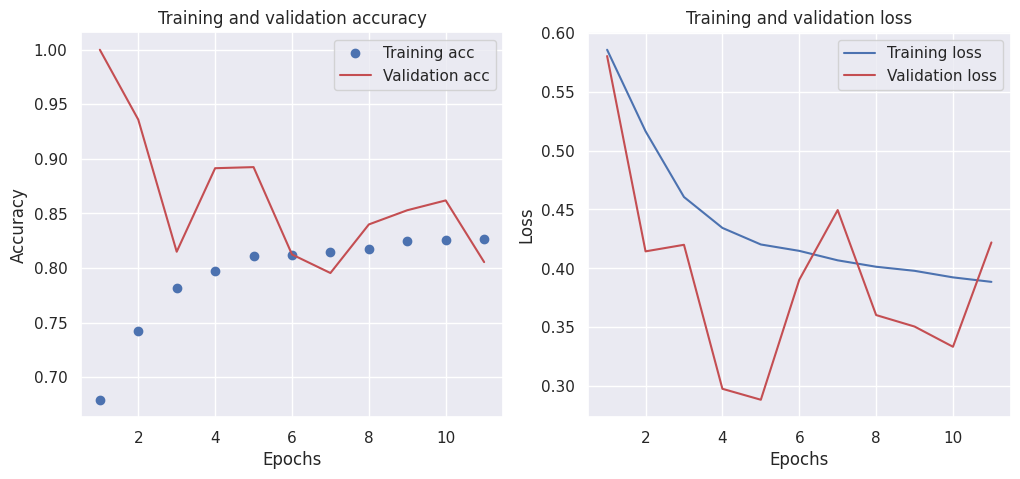

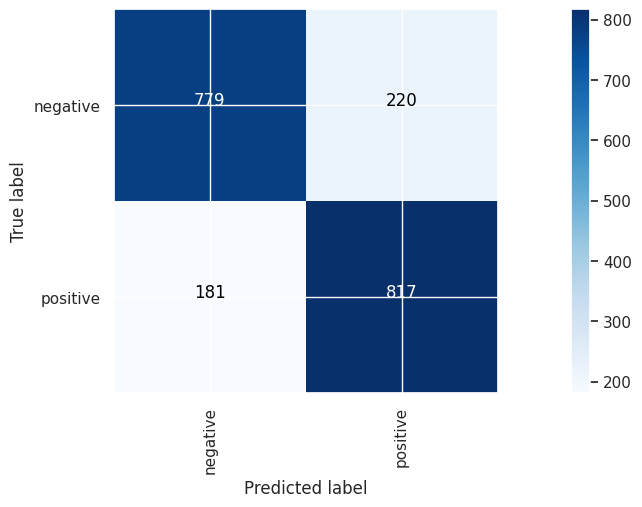

Final Accuracy
0.7991987981972959
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 600, 50)              1488650   ['input_37[0][0]']            
                                                                                                  
 conv1d_72 (Conv1D)          (None, 597, 64)              12864     ['embedding_11[0][0]']        
                                                                                                  
 batch_normalization_100 (B  (None, 597, 64)              256       ['conv1d_72[0][0]']           
 atchNormalization)                  

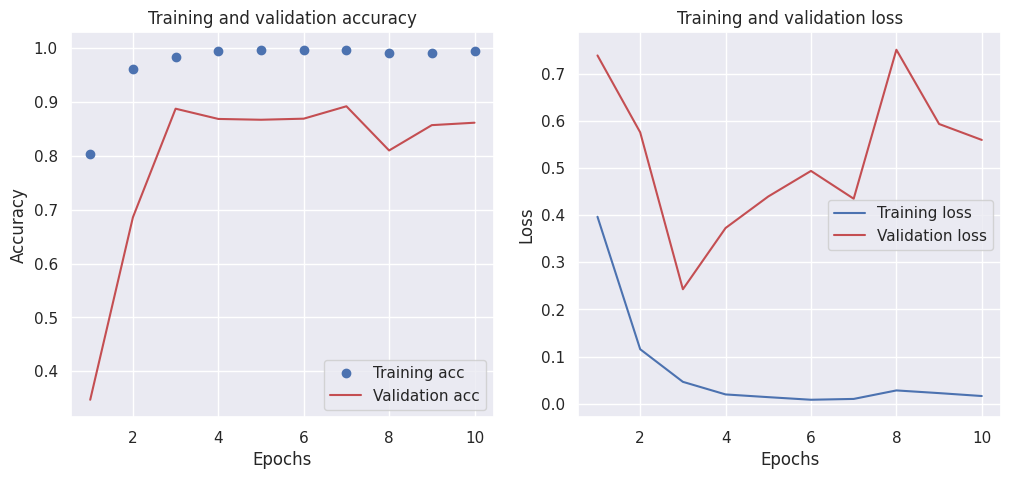

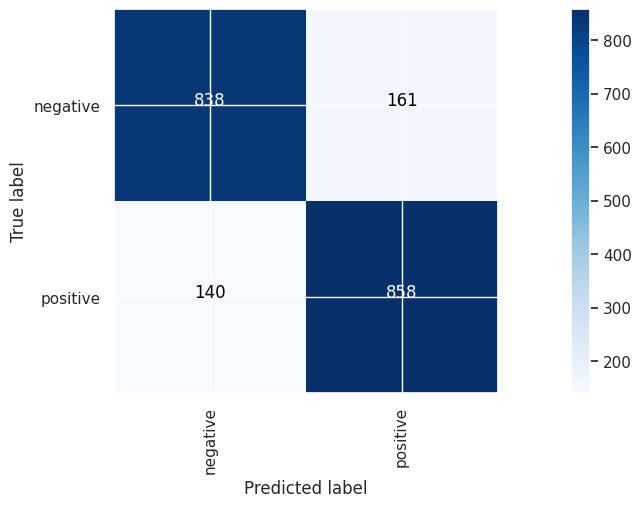

Final Accuracy
0.8492739108662994
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 600, 50)              1488650   ['input_38[0][0]']            
                                                                                                  
 conv1d_74 (Conv1D)          (None, 597, 64)              12864     ['embedding_12[0][0]']        
                                                                                                  
 batch_normalization_102 (B  (None, 597, 64)              256       ['conv1d_74[0][0]']           
 atchNormalization)                  

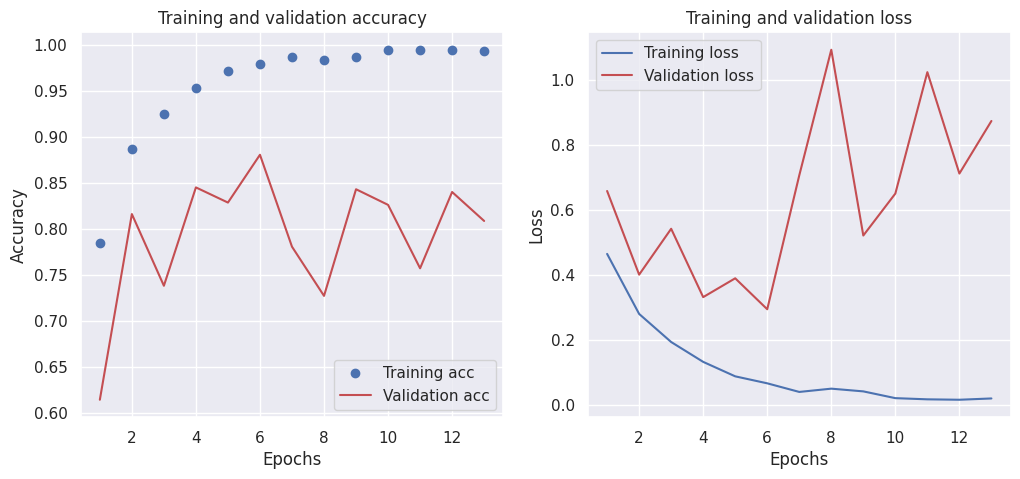

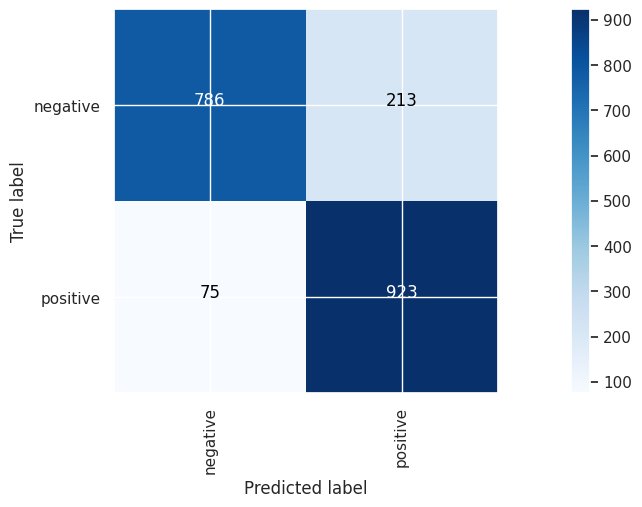

Final Accuracy
0.85578367551327


In [13]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[64,128],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.15,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[64,128]
kernel_size=4
dense_neurons=0
block_dropout=0.15
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_6.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_76 (Conv1D)          (None, 4997, 128)            640       ['input_39[0][0]']            
                                                                                                  
 batch_normalization_104 (B  (None, 4997, 128)            512       ['conv1d_76[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_105 (B  (None, 4997, 128)            512       ['c

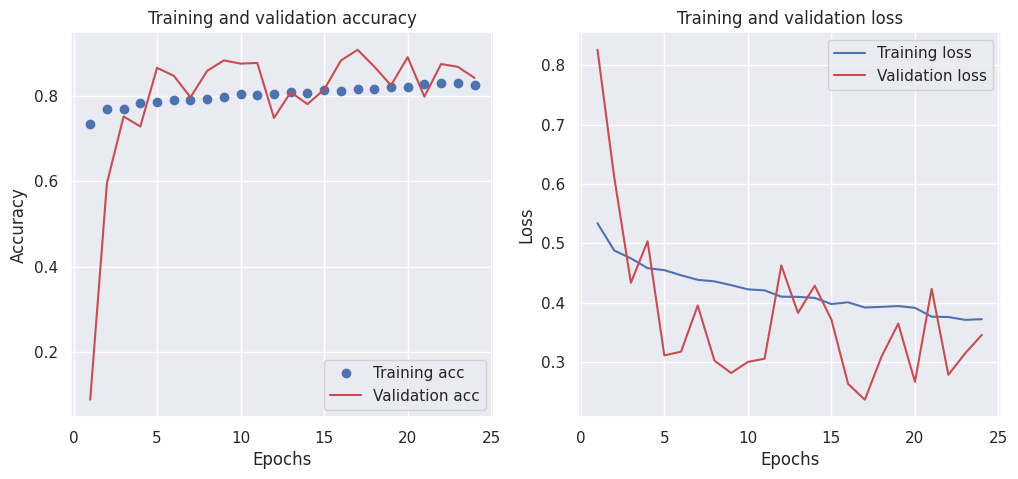

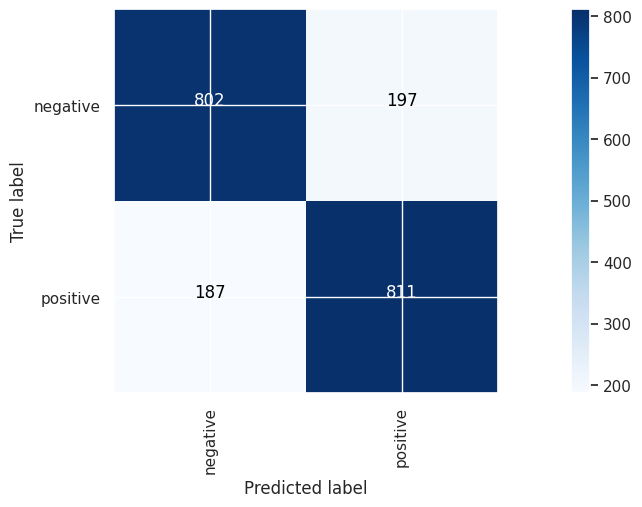

Final Accuracy
0.8077115673510266
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_78 (Conv1D)          (None, 4997, 128)            640       ['input_40[0][0]']            
                                                                                                  
 batch_normalization_106 (B  (None, 4997, 128)            512       ['conv1d_78[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_107 (B  (None, 4

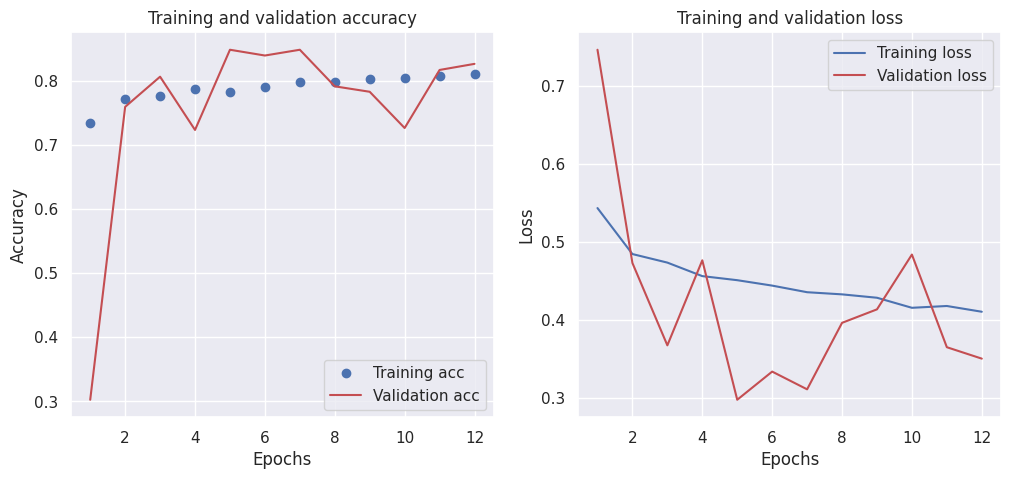

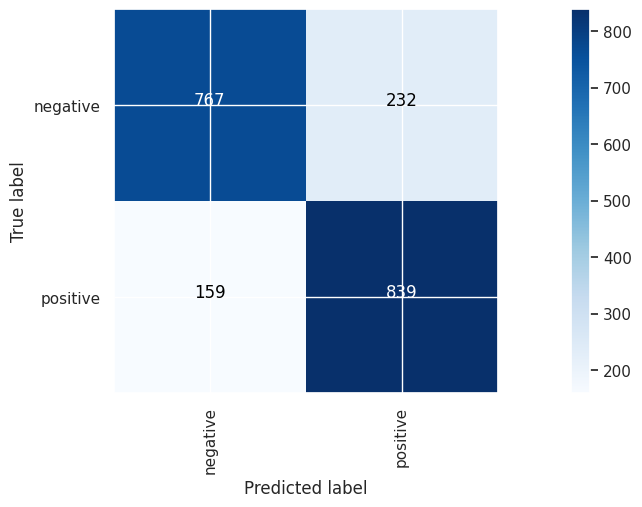

Final Accuracy
0.8042063094641962
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_80 (Conv1D)          (None, 4997, 128)            640       ['input_41[0][0]']            
                                                                                                  
 batch_normalization_108 (B  (None, 4997, 128)            512       ['conv1d_80[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_109 (B  (None, 4

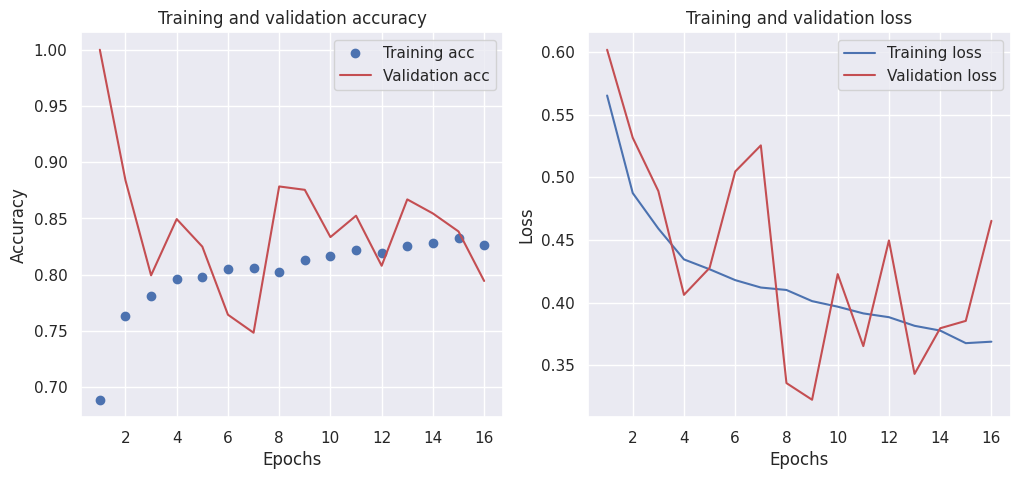

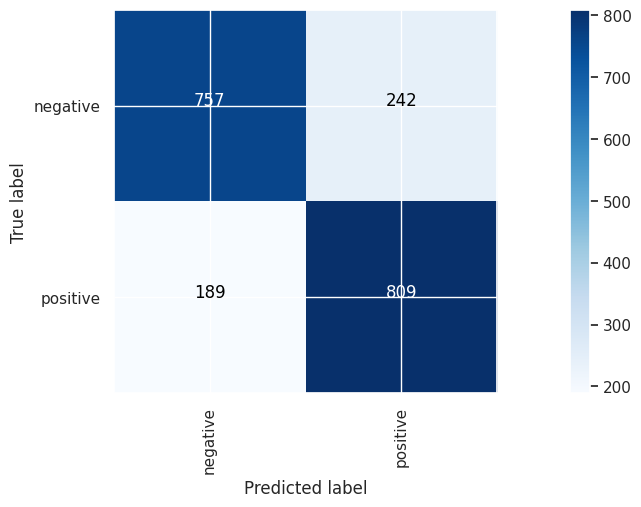

Final Accuracy
0.7841762643965949
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_82 (Conv1D)          (None, 4997, 128)            640       ['input_42[0][0]']            
                                                                                                  
 batch_normalization_110 (B  (None, 4997, 128)            512       ['conv1d_82[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_111 (B  (None, 4

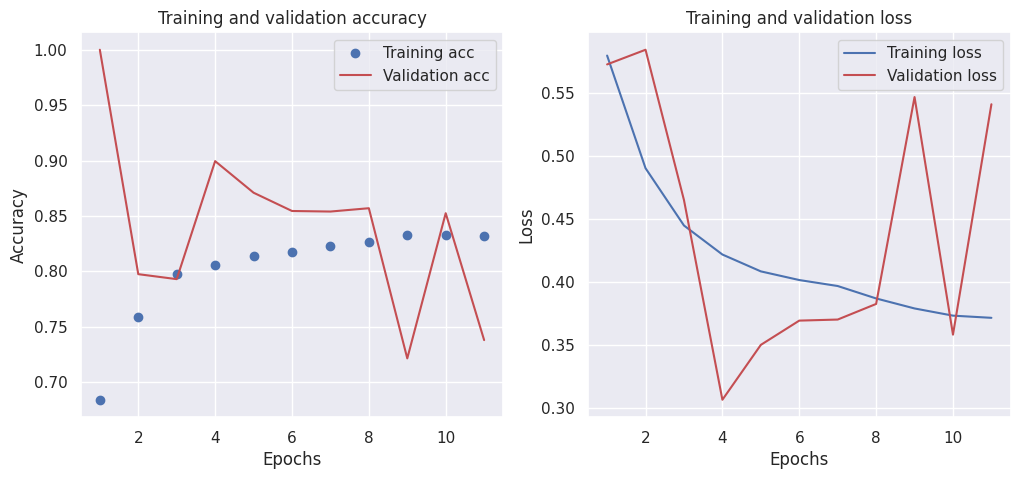

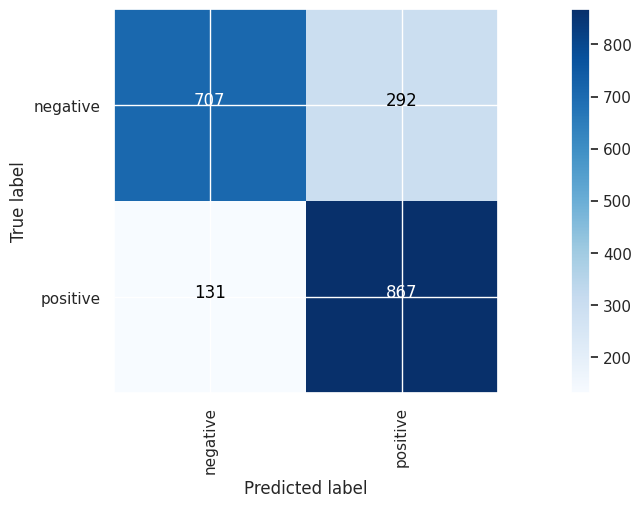

Final Accuracy
0.7881822734101152
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, 600, 50)              1488650   ['input_43[0][0]']            
                                                                                                  
 conv1d_84 (Conv1D)          (None, 597, 128)             25728     ['embedding_13[0][0]']        
                                                                                                  
 batch_normalization_112 (B  (None, 597, 128)             512       ['conv1d_84[0][0]']           
 atchNormalization)                  

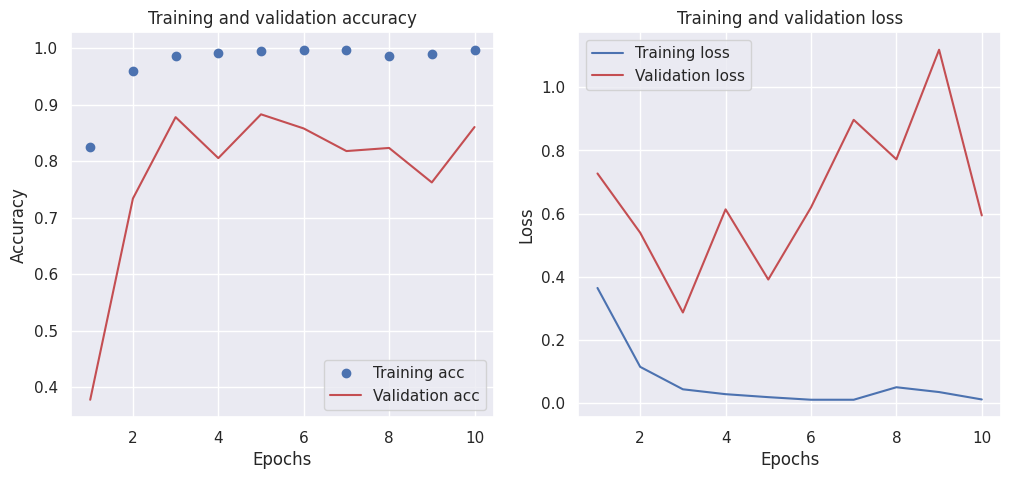

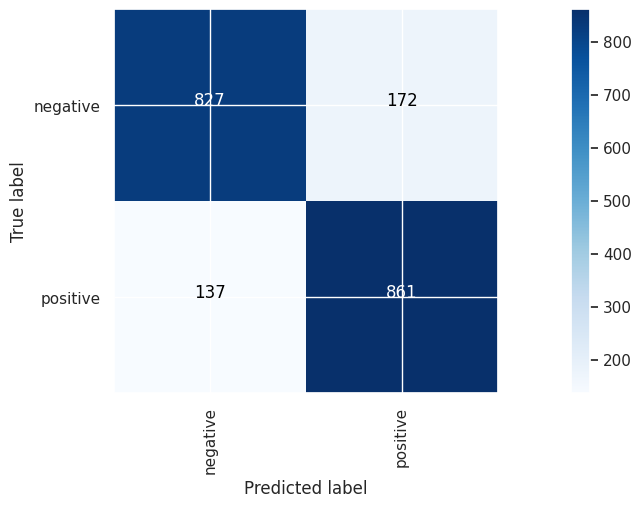

Final Accuracy
0.8452679018527791
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 600, 50)              1488650   ['input_44[0][0]']            
                                                                                                  
 conv1d_86 (Conv1D)          (None, 597, 128)             25728     ['embedding_14[0][0]']        
                                                                                                  
 batch_normalization_114 (B  (None, 597, 128)             512       ['conv1d_86[0][0]']           
 atchNormalization)                  

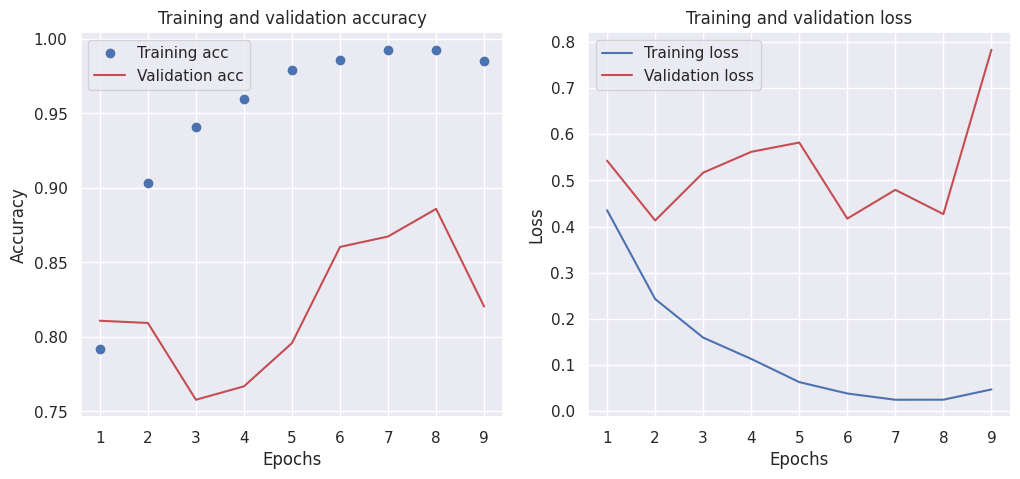

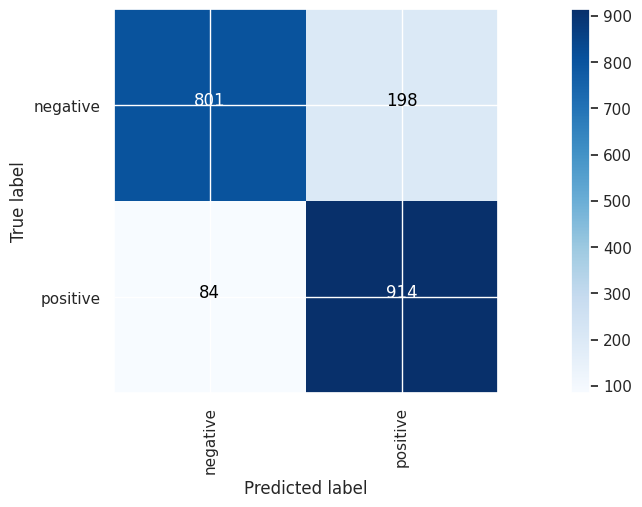

Final Accuracy
0.8587881822734101


In [14]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[128,256],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.15,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[128,256]
kernel_size=4
dense_neurons=0
block_dropout=0.15
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_7.csv", index=False)

Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_88 (Conv1D)          (None, 4997, 128)            640       ['input_45[0][0]']            
                                                                                                  
 batch_normalization_116 (B  (None, 4997, 128)            512       ['conv1d_88[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_117 (B  (None, 4997, 128)            512       ['c

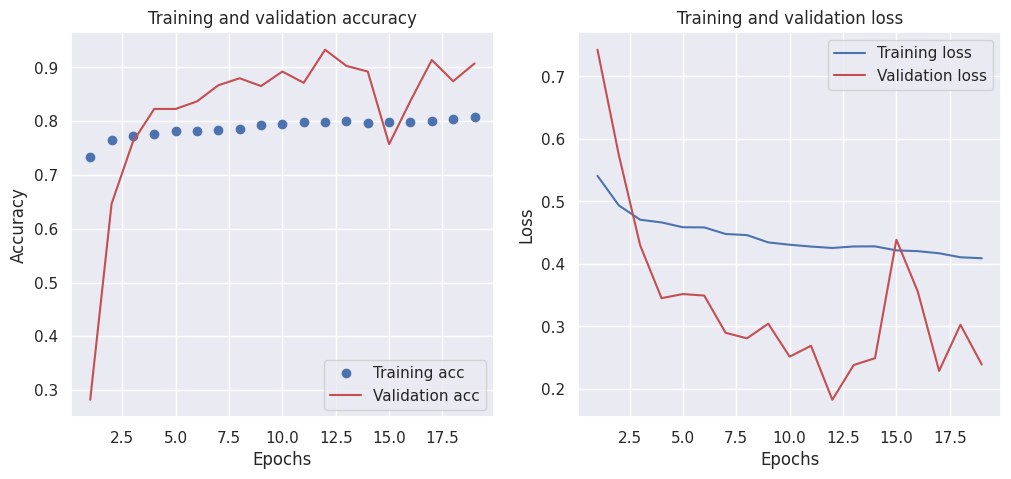

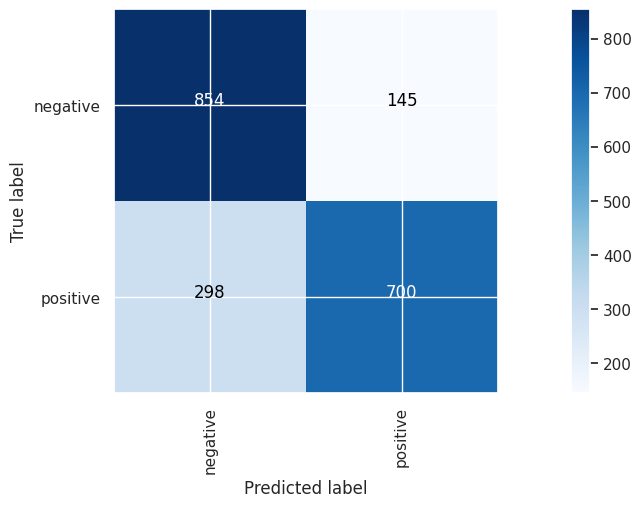

Final Accuracy
0.7781672508763144
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_90 (Conv1D)          (None, 4997, 128)            640       ['input_46[0][0]']            
                                                                                                  
 batch_normalization_118 (B  (None, 4997, 128)            512       ['conv1d_90[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_119 (B  (None, 4

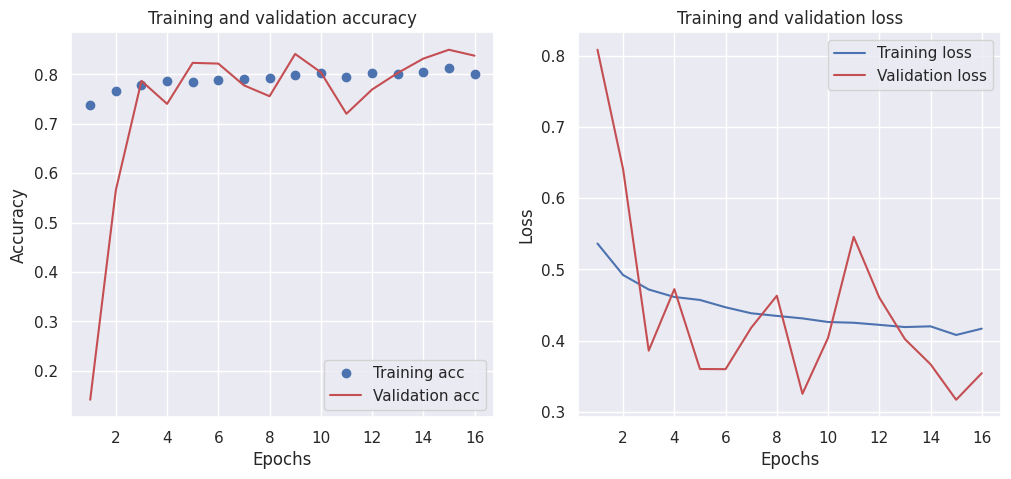

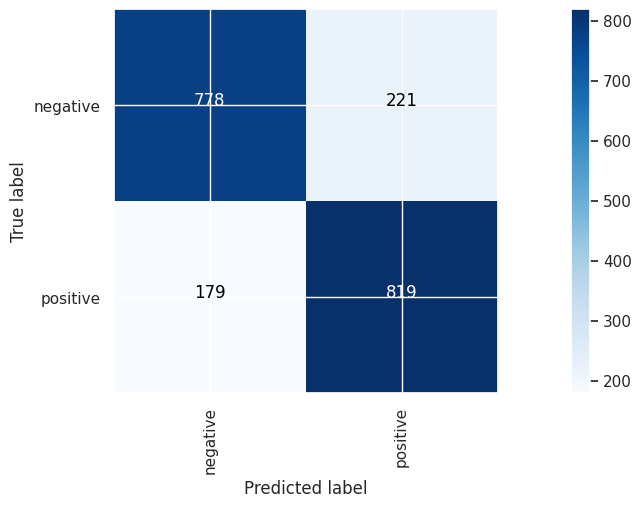

Final Accuracy
0.799699549323986
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_92 (Conv1D)          (None, 4997, 128)            640       ['input_47[0][0]']            
                                                                                                  
 batch_normalization_120 (B  (None, 4997, 128)            512       ['conv1d_92[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_121 (B  (None, 49

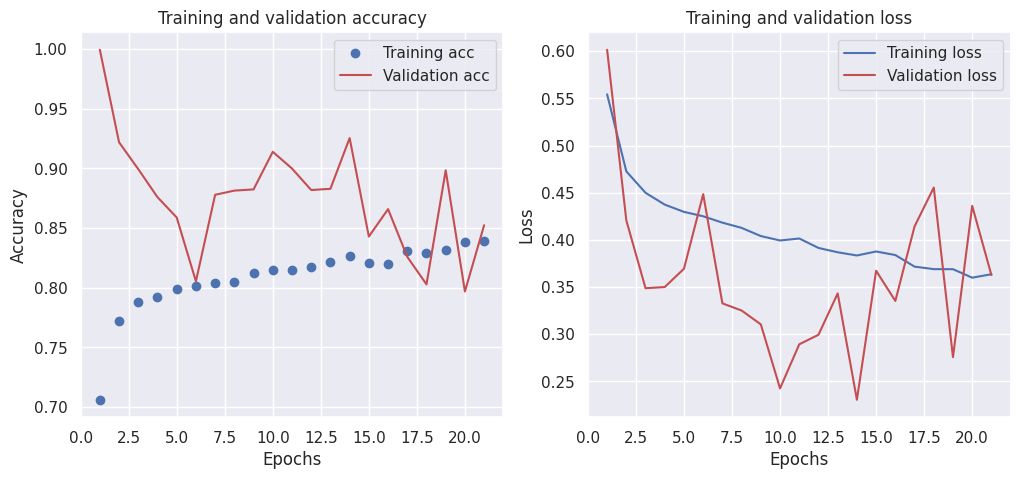

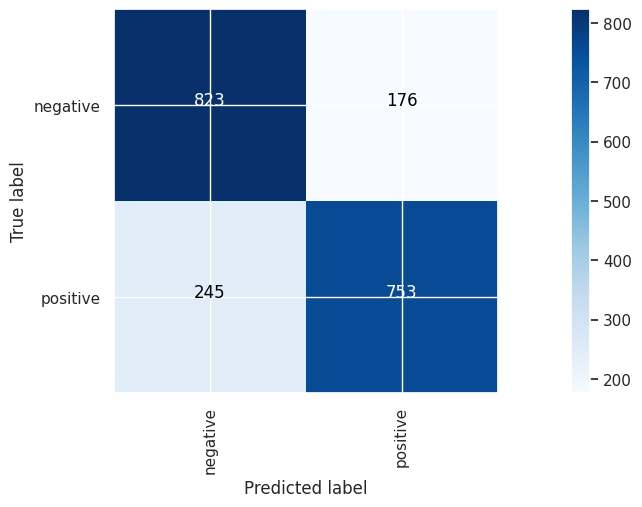

Final Accuracy
0.7891837756634953
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_94 (Conv1D)          (None, 4997, 128)            640       ['input_48[0][0]']            
                                                                                                  
 batch_normalization_122 (B  (None, 4997, 128)            512       ['conv1d_94[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_123 (B  (None, 4

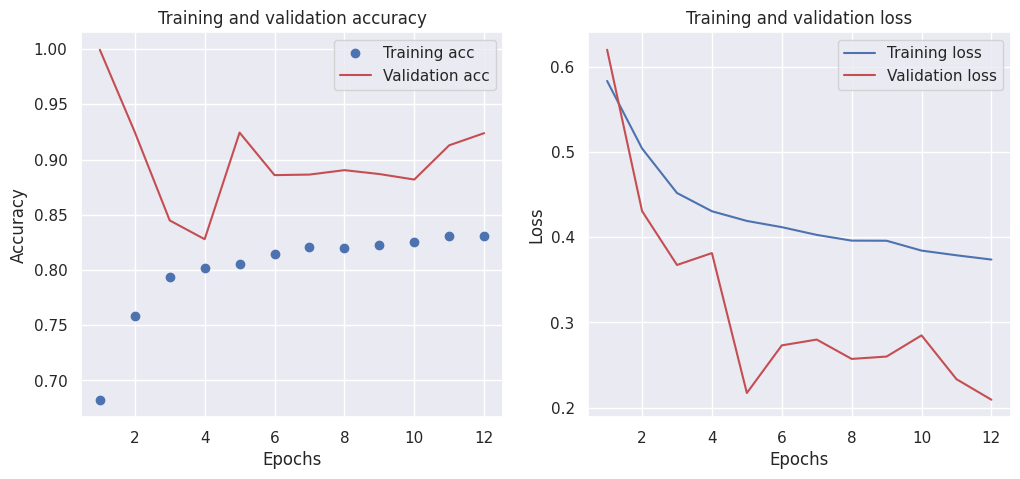

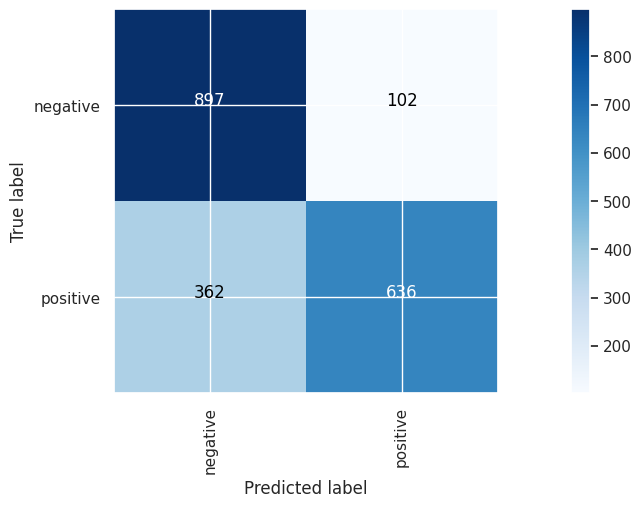

Final Accuracy
0.7676514772158237
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_15 (Embedding)    (None, 600, 50)              1488650   ['input_49[0][0]']            
                                                                                                  
 conv1d_96 (Conv1D)          (None, 597, 128)             25728     ['embedding_15[0][0]']        
                                                                                                  
 batch_normalization_124 (B  (None, 597, 128)             512       ['conv1d_96[0][0]']           
 atchNormalization)                  

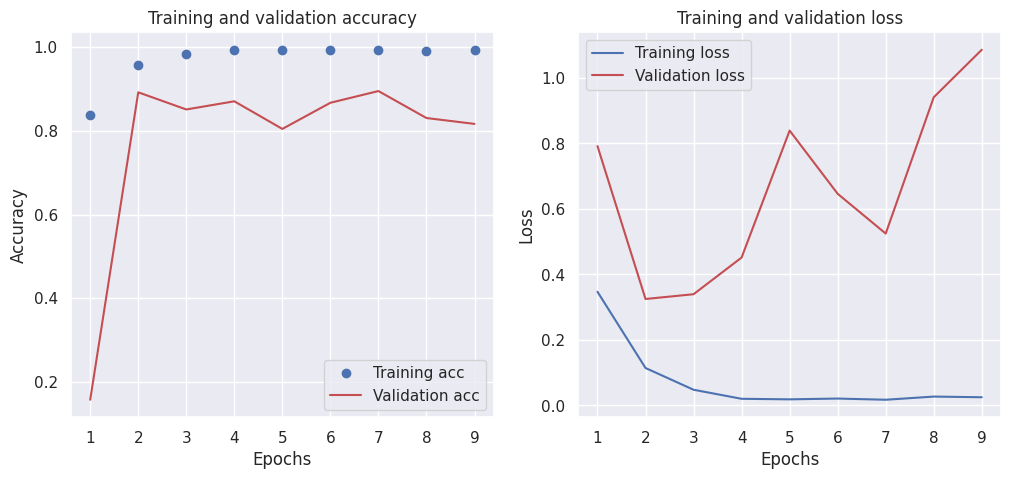

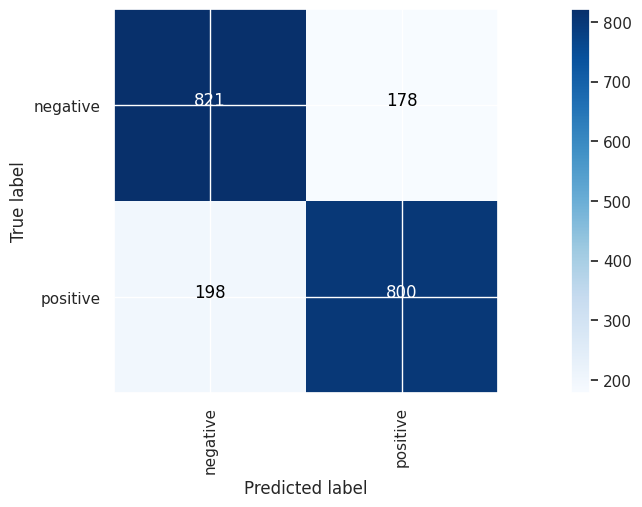

Final Accuracy
0.8117175763645468
Model: "Exp04ConvResidualConnections"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 600)]                0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 600, 50)              1488650   ['input_50[0][0]']            
                                                                                                  
 conv1d_98 (Conv1D)          (None, 597, 128)             25728     ['embedding_16[0][0]']        
                                                                                                  
 batch_normalization_126 (B  (None, 597, 128)             512       ['conv1d_98[0][0]']           
 atchNormalization)                  

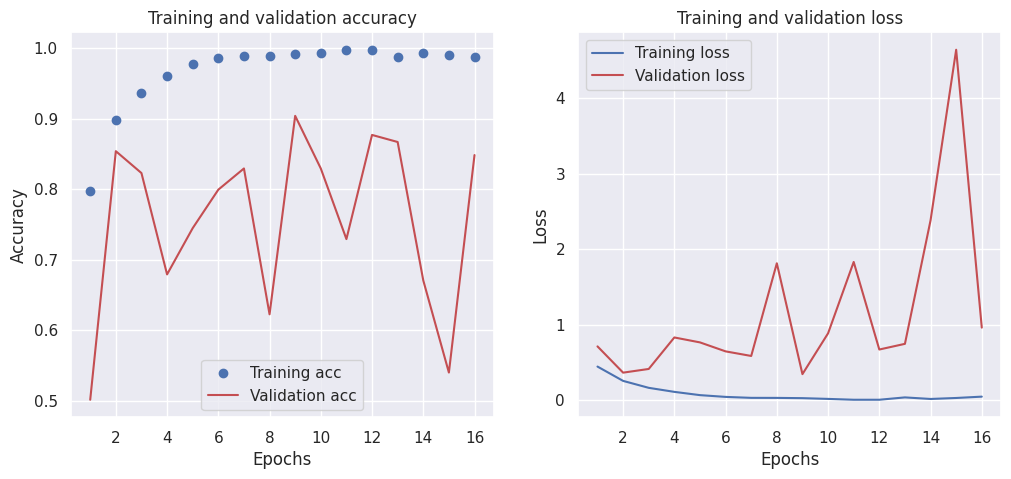

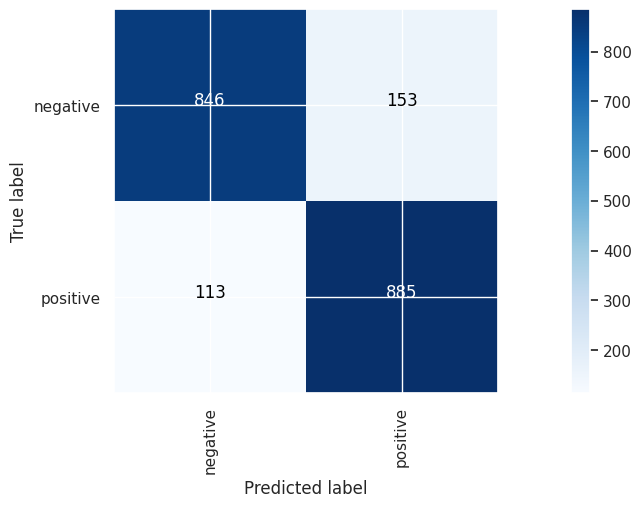

Final Accuracy
0.8668002003004507


In [15]:
# VSM models
results = []
name = "ConvResidualConnections"
description =   """
                number_of_filters=[128,256],
                kernel_size=4,
                dense_neurons=0,
                block_dropout=0.25,
                general_dropout=0.5, 
                pooling_size=4
                """
description = description.replace('\t', '').replace('\n', '').replace(' ', '')

number_of_filters=[128,256]
kernel_size=4
dense_neurons=0
block_dropout=0.25
general_dropout=0.5
pooling_size=4

# VSM models
results = []
for rep in vsm_model:
    build_exp04(name,
                description, 
                rep, 
                input_shape=(5000,1,),
                number_of_filters=number_of_filters,
                kernel_size=kernel_size,
                dense_neurons=dense_neurons,
                block_dropout=block_dropout,
                general_dropout=general_dropout, 
                pooling_size=pooling_size
                )

# Embedding with padding
embedding = layers.Embedding(input_dim=vocab_size,
                     output_dim=emb_dim,
                     trainable=True,
                     input_length=embedding_padding["train_text_features"].shape[1])
build_exp04(name,
            description, 
            embedding_padding, 
            input_shape=(embedding_padding["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size          
            )

# GloVe
embedding = layers.Embedding(num_words,
                     emb_dim,
                     embeddings_initializer=Constant(embedding_glove["embedding_matrix"]),
                     trainable=True,
                     input_length=embedding_glove["train_text_features"].shape[1])

build_exp04(name,
            description, 
            embedding_glove, 
            input_shape=(embedding_glove["train_text_features"].shape[1],),
            embedding=embedding,
            number_of_filters=number_of_filters,
            kernel_size=kernel_size,
            dense_neurons=dense_neurons,
            block_dropout=block_dropout,
            general_dropout=general_dropout, 
            pooling_size=pooling_size         
            )
partial = pd.DataFrame(results)
partial.to_csv("exp_04_8.csv", index=False)

## Conclusiones

In [18]:
join_csv_for_experiment("04", 8)
pd.read_csv("exp_04.csv").sort_values(by=["accuracy"], ascending=False, ignore_index=True)[["classifier", "rep.model", "accuracy"]]

classifier  \
0         Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.25,general_dropout=0.5,pooling_size=4   
1        Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.0,general_dropout=0.0,pooling_size=4   
2        Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.0,general_dropout=0.5,pooling_size=4   
3         Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
4          Exp04ConvResidualConnections number_of_filters=[64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
5           Exp04ConvResidualConnections number_of_filters=[32,64],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
6           Exp04ConvResidualConnections number_of_filters=[32,64],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
7          Exp04ConvResidualConnections number_of_filters=[64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
8       Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
9   Exp04ConvResidualConnections number_of_filters=[32,64,128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
10        Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
11       Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.0,general_dropout=0.5,pooling_size=4   
12       Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.0,general_dropout=0.0,pooling_size=4   
13  Exp04ConvResidualConnections number_of_filters=[32,64,128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
14        Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.25,general_dropout=0.5,pooling_size=4   
15      Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
16        Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
17      Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
18        Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
19      Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
20          Exp04ConvResidualConnections number_of_filters=[32,64],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
21      Exp04ConvResidualConnections number_of_filters=[32,64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
22         Exp04ConvResidualConnections number_of_filters=[64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
23        Exp04ConvResidualConnections number_of_filters=[128,256],kernel_size=4,dense_neurons=0,block_dropout=0.25,general_dropout=0.5,pooling_size=4   
24         Exp04ConvResidualConnections number_of_filters=[64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,pooling_size=4   
25         Exp04ConvResidualConnections number_of_filters=[64,128],kernel_size=4,dense_neurons=0,block_dropout=0.15,general_dropout=0.5,